# Ćwiczenie 5 - Klasyfikacja obrazów FashionMNIST

W tym ćwiczeniu wykorzystamy sieci wielowarstwowe do klasyfikacji obrazów ze zbioru FashionMNIST.

**Cel:**
Porównać wpływ różnych parametrów na jakość klasyfikacji dla sieci z **1 i 2 warstwami ukrytymi**:
- Liczba neuronów w warstwach ukrytych
- Rozmiar batcha
- Liczba przykładów uczących (1%, 10%, 100% danych)
- Zaburzenia danych (szum gaussowski)

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm

# Sprawdź czy GPU jest dostępne
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Definicja modeli

In [7]:
class OneHiddenLayerNet(nn.Module):
    """
    Sieć z 1 warstwą ukrytą.
    Architektura: Input -> Flatten -> Linear(128) -> ReLU -> Linear(10)
    """
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(OneHiddenLayerNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x


class TwoHiddenLayersNet(nn.Module):
    """
    Sieć z 2 warstwami ukrytymi.
    Architektura: Input -> Flatten -> Linear(128) -> ReLU -> Linear(64) -> ReLU -> Linear(10)
    """
    def __init__(self, input_size=784, hidden_size1=128, hidden_size2=64, num_classes=10):
        super(TwoHiddenLayersNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

## Funkcje pomocnicze

In [10]:
def load_data(batch_size=64, data_fraction=1.0, noise_std=0.0):
    """
    Wczytuje i przygotowuje dane FashionMNIST.
    
    Args:
        batch_size: Rozmiar batcha
        data_fraction: Frakcja danych do wykorzystania (0.01, 0.1, 1.0)
        noise_std: Odchylenie standardowe szumu gaussowskiego
    """
    # Transformacje
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Wczytaj dane
    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform
    )
    
    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform
    )
    
    # Ogranicz rozmiar zbioru treningowego
    if data_fraction < 1.0:
        train_size = int(len(train_dataset) * data_fraction)
        indices = np.random.choice(len(train_dataset), train_size, replace=False)
        train_dataset = Subset(train_dataset, indices)
    
    # Stwórz DataLoadery
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


def add_noise(images, noise_std=0.0):
    """
    Dodaje szum gaussowski do obrazów.
    """
    if noise_std > 0:
        noise = torch.randn_like(images) * noise_std
        images = images + noise
        images = torch.clamp(images, -1, 1)  # Ogranicz do zakresu [-1, 1]
    return images


def test_configuration(model_type, hidden_size=128, batch_size=64, 
                      data_fraction=1.0, epochs=10, 
                      train_noise_std=0.0, test_noise_std=0.0):
    """
    Testuje pojedynczą konfigurację parametrów.
    """
    # Wczytaj dane
    train_loader, test_loader = load_data(batch_size, data_fraction)
    
    # Stwórz model
    if model_type == 'one':
        model = OneHiddenLayerNet(hidden_size=hidden_size)
    else:
        model = TwoHiddenLayersNet(hidden_size1=hidden_size, hidden_size2=hidden_size//2)
    
    # Optimizer i funkcja kosztu
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Trenuj
    history = train_model(model, train_loader, test_loader, optimizer, criterion,
                         epochs=epochs, device=device, 
                         train_noise_std=train_noise_std, 
                         test_noise_std=test_noise_std)
    
    return history, model


In [9]:
def train_model(model, train_loader, test_loader, optimizer, criterion, 
                epochs=10, device='cpu', train_noise_std=0.0, test_noise_std=0.0):
    """
    Trenuje model i zwraca historię.
    """
    model = model.to(device)
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # ============ TRENING ============
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = add_noise(images, train_noise_std)
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        
        # ============ WALIDACJA ============
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = add_noise(images, test_noise_std)
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        test_epoch_loss = test_loss / test_total
        test_epoch_acc = test_correct / test_total
        
        # Zapisz historię
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['test_loss'].append(test_epoch_loss)
        history['test_acc'].append(test_epoch_acc)
        
        # Print progress co 5 epok
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            tqdm.write(f"Epoch {epoch+1}/{epochs} | "
                      f"Train loss={epoch_loss:.4f} acc={epoch_acc:.4f} | "
                      f"Test loss={test_epoch_loss:.4f} acc={test_epoch_acc:.4f}")
    
    return history


## Funkcje do wizualizacji

In [18]:
def plot_comparison(results, title):
    """
    Rysuje wykresy porównawcze dla różnych konfiguracji.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for r in results:
        label = r['label']
        axes[0].plot(r['history']['train_loss'], label=label, linewidth=2)
        axes[1].plot(r['history']['test_acc'], label=label, linewidth=2)
    
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Train Loss', fontsize=11)
    axes[0].set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=9)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Test Accuracy', fontsize=11)
    axes[1].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=9)
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def print_summary_table(results):
    """
    Drukuje tabelę podsumowującą wyniki.
    """
    print("\n" + "="*90)
    print("PODSUMOWANIE WYNIKÓW")
    print("="*90)
    print(f"{'Konfiguracja':<45} {'Train Acc':>12} {'Test Acc':>12} {'Gap':>10}")
    print("-"*90)
    
    for r in results:
        train_acc = r['history']['train_acc'][-1]
        test_acc = r['history']['test_acc'][-1]
        gap = train_acc - test_acc
        print(f"{r['label']:<45} {train_acc:>12.4f} {test_acc:>12.4f} {gap:>10.4f}")
    
    print("="*90)


def plot_comparison_separate(results_one, results_two, title):
    """
    Rysuje 4 wykresy: 2 dla modelu 1-warstwowego, 2 dla 2-warstwowego.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # GÓRNY RZĄD: 1 warstwa ukryta
    # Train Loss
    for r in results_one:
        axes[0, 0].plot(r['history']['train_loss'], label=r['label'], linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Train Loss', fontsize=11)
    axes[0, 0].set_title('1 Warstwa Ukryta - Training Loss', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=9)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Test Accuracy
    for r in results_one:
        axes[0, 1].plot(r['history']['test_acc'], label=r['label'], linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Test Accuracy', fontsize=11)
    axes[0, 1].set_title('1 Warstwa Ukryta - Test Accuracy', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(True, alpha=0.3)
    
    # DOLNY RZĄD: 2 warstwy ukryte
    # Train Loss
    for r in results_two:
        axes[1, 0].plot(r['history']['train_loss'], label=r['label'], linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Train Loss', fontsize=11)
    axes[1, 0].set_title('2 Warstwy Ukryte - Training Loss', fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=9)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Test Accuracy
    for r in results_two:
        axes[1, 1].plot(r['history']['test_acc'], label=r['label'], linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Test Accuracy', fontsize=11)
    axes[1, 1].set_title('2 Warstwy Ukryte - Test Accuracy', fontsize=12, fontweight='bold')
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Eksperymenty

## Eksperyment 1: Porównanie 1 vs 2 warstwy ukryte

**Cel:**
Sprawdzić, jak dodanie drugiej warstwy ukrytej wpływa na zdolność sieci do uczenia się i generalizacji.

**Ustawienia:**
- Modele: 
  - OneHiddenLayerNet: 784 → 128 → 10
  - TwoHiddenLayersNet: 784 → 128 → 64 → 10
- Liczba epok: 20
- Batch size: 64
- Stałe parametry: learning rate = 0.001, optimizer = Adam


=== Eksperyment 1: 1 warstwa ukryta vs 2 warstwy ukryte ===

--- Trenowanie modelu z 1 warstwą ukrytą (128 neuronów) ---


Training Progress:   5%|▌         | 1/20 [00:04<01:19,  4.18s/it]

Epoch 1/20 | Train loss=0.5077 acc=0.8196 | Test loss=0.4334 acc=0.8428


Training Progress:  25%|██▌       | 5/20 [00:21<01:05,  4.36s/it]

Epoch 5/20 | Train loss=0.2984 acc=0.8899 | Test loss=0.3610 acc=0.8700


Training Progress:  50%|█████     | 10/20 [00:44<00:45,  4.60s/it]

Epoch 10/20 | Train loss=0.2437 acc=0.9100 | Test loss=0.3447 acc=0.8767


Training Progress:  75%|███████▌  | 15/20 [01:05<00:22,  4.43s/it]

Epoch 15/20 | Train loss=0.2076 acc=0.9225 | Test loss=0.3643 acc=0.8779


Training Progress: 100%|██████████| 20/20 [01:29<00:00,  4.45s/it]


Epoch 20/20 | Train loss=0.1792 acc=0.9331 | Test loss=0.3811 acc=0.8815

--- Trenowanie modelu z 2 warstwami ukrytymi (128→64) ---


Training Progress:   5%|▌         | 1/20 [00:04<01:28,  4.66s/it]

Epoch 1/20 | Train loss=0.5188 acc=0.8136 | Test loss=0.4188 acc=0.8488


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.49s/it]

Epoch 5/20 | Train loss=0.3014 acc=0.8880 | Test loss=0.3779 acc=0.8635


Training Progress:  50%|█████     | 10/20 [00:44<00:44,  4.42s/it]

Epoch 10/20 | Train loss=0.2382 acc=0.9105 | Test loss=0.3402 acc=0.8792


Training Progress:  75%|███████▌  | 15/20 [01:07<00:22,  4.53s/it]

Epoch 15/20 | Train loss=0.1998 acc=0.9248 | Test loss=0.3617 acc=0.8841


Training Progress: 100%|██████████| 20/20 [01:29<00:00,  4.46s/it]


Epoch 20/20 | Train loss=0.1689 acc=0.9365 | Test loss=0.3881 acc=0.8839


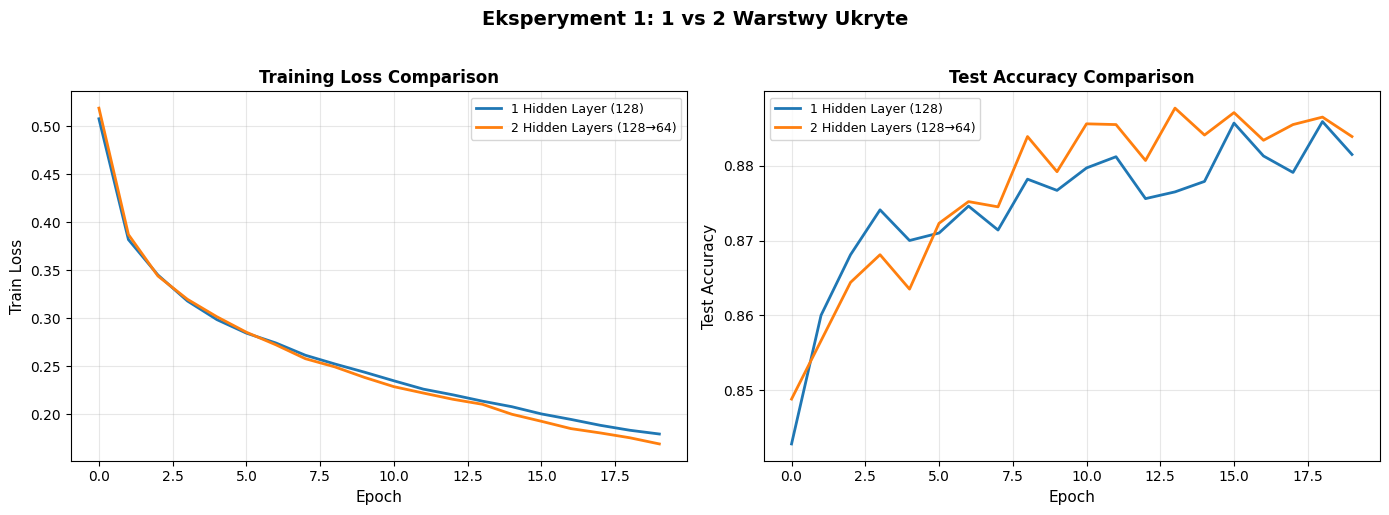


PODSUMOWANIE WYNIKÓW
Konfiguracja                                     Train Acc     Test Acc        Gap
------------------------------------------------------------------------------------------
1 Hidden Layer (128)                                0.9331       0.8815     0.0516
2 Hidden Layers (128→64)                            0.9365       0.8839     0.0526


In [12]:
print("\n=== Eksperyment 1: 1 warstwa ukryta vs 2 warstwy ukryte ===")

results_model_comparison = []

# 1 warstwa ukryta
print("\n--- Trenowanie modelu z 1 warstwą ukrytą (128 neuronów) ---")
history, model = test_configuration(
    model_type='one',
    hidden_size=128,
    batch_size=64,
    epochs=20
)
results_model_comparison.append({
    'label': '1 Hidden Layer (128)',
    'history': history
})

# 2 warstwy ukryte
print("\n--- Trenowanie modelu z 2 warstwami ukrytymi (128→64) ---")
history, model = test_configuration(
    model_type='two',
    hidden_size=128,
    batch_size=64,
    epochs=20
)
results_model_comparison.append({
    'label': '2 Hidden Layers (128→64)',
    'history': history
})

plot_comparison(results_model_comparison, 
               "Eksperyment 1: 1 vs 2 Warstwy Ukryte")
print_summary_table(results_model_comparison)

### Wnioski - Eksperyment 1:

**1 warstwa ukryta (784→128→10):**
- Train Acc: 93.31%, Test Acc: 88.15%, Gap: 5.16%
- Loss spada stabilnie z 0.51 do 0.18
- Dobra generalizacja

**2 warstwy ukryte (784→128→64→10):**
- Train Acc: 93.65%, Test Acc: 88.39%, Gap: 5.26%
- **+0.24% lepsza Test Accuracy**
- Nieznacznie niższy train loss (0.17 vs 0.18)

**Porównanie:**
- Model z 2 warstwami uczy się minimalnie lepiej (~0.3% różnicy)
- Podobny gap (5.16% vs 5.26%) - obie sieci generalizują podobnie
- Identyczny czas treningu
- Dodatkowa warstwa nie daje znaczącej poprawy dla FashionMNIST

**Ogólny wniosek:**
Dla FashionMNIST (prosty dataset) 1 warstwa ukryta wystarcza. Dodanie 2. warstwy daje minimalną poprawę (+0.24%), ale zwiększa złożoność modelu. Trade-off nie jest opłacalny - **1 warstwa ukryta jest optymalnym wyborem** dla tego zadania (prostota + wydajność).

## Eksperyment 2: Wpływ liczby neuronów w warstwie ukrytej

**Cel:**
Zbadać, jak rozmiar warstwy ukrytej wpływa na zdolność sieci do uczenia się i ryzyko overfittingu.

**Ustawienia:**
- Hidden sizes: [32, 64, 128, 256, 512]
- Liczba epok: 20
- Batch size: 64


=== Eksperyment 2: Wpływ liczby neuronów w warstwie ukrytej ===

--- 1 warstwa, Hidden size: 32 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:18,  4.12s/it]

Epoch 1/20 | Train loss=0.5488 acc=0.8070 | Test loss=0.4786 acc=0.8285


Training Progress:  25%|██▌       | 5/20 [00:19<00:58,  3.91s/it]

Epoch 5/20 | Train loss=0.3478 acc=0.8740 | Test loss=0.3957 acc=0.8571


Training Progress:  50%|█████     | 10/20 [00:38<00:38,  3.86s/it]

Epoch 10/20 | Train loss=0.3023 acc=0.8901 | Test loss=0.3682 acc=0.8662


Training Progress:  75%|███████▌  | 15/20 [00:58<00:19,  3.86s/it]

Epoch 15/20 | Train loss=0.2756 acc=0.8990 | Test loss=0.3737 acc=0.8685


Training Progress: 100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


Epoch 20/20 | Train loss=0.2558 acc=0.9057 | Test loss=0.3736 acc=0.8705

--- 1 warstwa, Hidden size: 64 ---


Training Progress:   5%|▌         | 1/20 [00:03<01:15,  3.96s/it]

Epoch 1/20 | Train loss=0.5201 acc=0.8150 | Test loss=0.4361 acc=0.8423


Training Progress:  25%|██▌       | 5/20 [00:19<00:59,  3.95s/it]

Epoch 5/20 | Train loss=0.3162 acc=0.8830 | Test loss=0.3659 acc=0.8647


Training Progress:  50%|█████     | 10/20 [00:40<00:40,  4.05s/it]

Epoch 10/20 | Train loss=0.2642 acc=0.9025 | Test loss=0.3683 acc=0.8733


Training Progress:  75%|███████▌  | 15/20 [01:00<00:20,  4.13s/it]

Epoch 15/20 | Train loss=0.2316 acc=0.9131 | Test loss=0.3665 acc=0.8772


Training Progress: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Epoch 20/20 | Train loss=0.2117 acc=0.9218 | Test loss=0.3843 acc=0.8800

--- 1 warstwa, Hidden size: 128 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:22,  4.36s/it]

Epoch 1/20 | Train loss=0.5047 acc=0.8172 | Test loss=0.4374 acc=0.8423


Training Progress:  25%|██▌       | 5/20 [00:21<01:05,  4.34s/it]

Epoch 5/20 | Train loss=0.2978 acc=0.8900 | Test loss=0.3444 acc=0.8774


Training Progress:  50%|█████     | 10/20 [00:43<00:43,  4.34s/it]

Epoch 10/20 | Train loss=0.2402 acc=0.9117 | Test loss=0.3562 acc=0.8775


Training Progress:  75%|███████▌  | 15/20 [01:05<00:21,  4.38s/it]

Epoch 15/20 | Train loss=0.2027 acc=0.9245 | Test loss=0.3552 acc=0.8801


Training Progress: 100%|██████████| 20/20 [01:27<00:00,  4.37s/it]


Epoch 20/20 | Train loss=0.1740 acc=0.9348 | Test loss=0.3922 acc=0.8739

--- 1 warstwa, Hidden size: 256 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:28,  4.64s/it]

Epoch 1/20 | Train loss=0.4868 acc=0.8229 | Test loss=0.4532 acc=0.8359


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.66s/it]

Epoch 5/20 | Train loss=0.2919 acc=0.8919 | Test loss=0.3781 acc=0.8681


Training Progress:  50%|█████     | 10/20 [00:46<00:46,  4.67s/it]

Epoch 10/20 | Train loss=0.2264 acc=0.9146 | Test loss=0.3553 acc=0.8763


Training Progress:  75%|███████▌  | 15/20 [01:10<00:23,  4.70s/it]

Epoch 15/20 | Train loss=0.1867 acc=0.9299 | Test loss=0.3663 acc=0.8833


Training Progress: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


Epoch 20/20 | Train loss=0.1580 acc=0.9409 | Test loss=0.3941 acc=0.8852

--- 1 warstwa, Hidden size: 512 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:43,  5.43s/it]

Epoch 1/20 | Train loss=0.4780 acc=0.8250 | Test loss=0.4159 acc=0.8496


Training Progress:  25%|██▌       | 5/20 [00:27<01:21,  5.45s/it]

Epoch 5/20 | Train loss=0.2849 acc=0.8944 | Test loss=0.3591 acc=0.8741


Training Progress:  50%|█████     | 10/20 [00:54<00:55,  5.51s/it]

Epoch 10/20 | Train loss=0.2183 acc=0.9184 | Test loss=0.3467 acc=0.8856


Training Progress:  75%|███████▌  | 15/20 [01:24<00:29,  5.82s/it]

Epoch 15/20 | Train loss=0.1769 acc=0.9335 | Test loss=0.3617 acc=0.8848


Training Progress:  80%|████████  | 16/20 [01:31<00:24,  6.14s/it]

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}


Training Progress: 100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


Epoch 20/20 | Train loss=0.1462 acc=0.9450 | Test loss=0.4085 acc=0.8821

--- 2 warstwy, Hidden size: 32 ---


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}


Training Progress:   5%|▌         | 1/20 [00:05<01:37,  5.11s/it]

Epoch 1/20 | Train loss=0.5892 acc=0.7884 | Test loss=0.4647 acc=0.8364


Training Progress:  15%|█▌        | 3/20 [00:14<01:23,  4.91s/it]

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/it]

Epoch 5/20 | Train loss=0.3455 acc=0.8762 | Test loss=0.3872 acc=0.8628


Training Progress:  30%|███       | 6/20 [00:29<01:07,  4.84s/it]

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}


Training Progress:  50%|█████     | 10/20 [00:47<00:46,  4.62s/it]

Epoch 10/20 | Train loss=0.3018 acc=0.8888 | Test loss=0.3806 acc=0.8664


Training Progress:  75%|███████▌  | 15/20 [01:10<00:22,  4.51s/it]

Epoch 15/20 | Train loss=0.2757 acc=0.8985 | Test loss=0.3842 acc=0.8647


Training Progress: 100%|██████████| 20/20 [01:32<00:00,  4.63s/it]


Epoch 20/20 | Train loss=0.2565 acc=0.9042 | Test loss=0.3690 acc=0.8717

--- 2 warstwy, Hidden size: 64 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:25,  4.52s/it]

Epoch 1/20 | Train loss=0.5478 acc=0.8039 | Test loss=0.4694 acc=0.8325


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.52s/it]

Epoch 5/20 | Train loss=0.3177 acc=0.8833 | Test loss=0.3679 acc=0.8693


Training Progress:  50%|█████     | 10/20 [00:45<00:45,  4.54s/it]

Epoch 10/20 | Train loss=0.2635 acc=0.9026 | Test loss=0.3711 acc=0.8745


Training Progress:  75%|███████▌  | 15/20 [01:08<00:22,  4.54s/it]

Epoch 15/20 | Train loss=0.2296 acc=0.9143 | Test loss=0.3625 acc=0.8807


Training Progress: 100%|██████████| 20/20 [01:30<00:00,  4.54s/it]


Epoch 20/20 | Train loss=0.2067 acc=0.9229 | Test loss=0.3643 acc=0.8825

--- 2 warstwy, Hidden size: 128 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:30,  4.74s/it]

Epoch 1/20 | Train loss=0.5157 acc=0.8154 | Test loss=0.4393 acc=0.8404


Training Progress:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/it]

Epoch 5/20 | Train loss=0.2990 acc=0.8887 | Test loss=0.3537 acc=0.8753


Training Progress:  50%|█████     | 10/20 [00:46<00:46,  4.65s/it]

Epoch 10/20 | Train loss=0.2378 acc=0.9121 | Test loss=0.3434 acc=0.8810


Training Progress:  75%|███████▌  | 15/20 [01:09<00:23,  4.65s/it]

Epoch 15/20 | Train loss=0.1986 acc=0.9254 | Test loss=0.3540 acc=0.8834


Training Progress:  80%|████████  | 16/20 [01:14<00:18,  4.69s/it]

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}


Training Progress:  90%|█████████ | 18/20 [01:24<00:09,  4.89s/it]

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}


Training Progress: 100%|██████████| 20/20 [01:33<00:00,  4.70s/it]


Epoch 20/20 | Train loss=0.1701 acc=0.9352 | Test loss=0.3598 acc=0.8920

--- 2 warstwy, Hidden size: 256 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:36,  5.10s/it]

Epoch 1/20 | Train loss=0.4937 acc=0.8202 | Test loss=0.4403 acc=0.8360


Training Progress:  25%|██▌       | 5/20 [00:25<01:14,  4.99s/it]

Epoch 5/20 | Train loss=0.2830 acc=0.8942 | Test loss=0.3535 acc=0.8737


Training Progress:  50%|█████     | 10/20 [00:49<00:49,  4.98s/it]

Epoch 10/20 | Train loss=0.2178 acc=0.9178 | Test loss=0.3614 acc=0.8751


Training Progress:  75%|███████▌  | 15/20 [01:14<00:24,  5.00s/it]

Epoch 15/20 | Train loss=0.1772 acc=0.9327 | Test loss=0.3536 acc=0.8864


Training Progress: 100%|██████████| 20/20 [01:39<00:00,  4.99s/it]


Epoch 20/20 | Train loss=0.1414 acc=0.9459 | Test loss=0.4032 acc=0.8834

--- 2 warstwy, Hidden size: 512 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:51,  5.87s/it]

Epoch 1/20 | Train loss=0.4819 acc=0.8226 | Test loss=0.4009 acc=0.8572


Training Progress:  25%|██▌       | 5/20 [00:29<01:28,  5.89s/it]

Epoch 5/20 | Train loss=0.2797 acc=0.8956 | Test loss=0.3359 acc=0.8774


Training Progress:  50%|█████     | 10/20 [00:58<00:59,  5.92s/it]

Epoch 10/20 | Train loss=0.2093 acc=0.9188 | Test loss=0.3353 acc=0.8860


Training Progress:  75%|███████▌  | 15/20 [01:28<00:29,  5.92s/it]

Epoch 15/20 | Train loss=0.1630 acc=0.9374 | Test loss=0.3702 acc=0.8829


Training Progress: 100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


Epoch 20/20 | Train loss=0.1267 acc=0.9517 | Test loss=0.4215 acc=0.8913


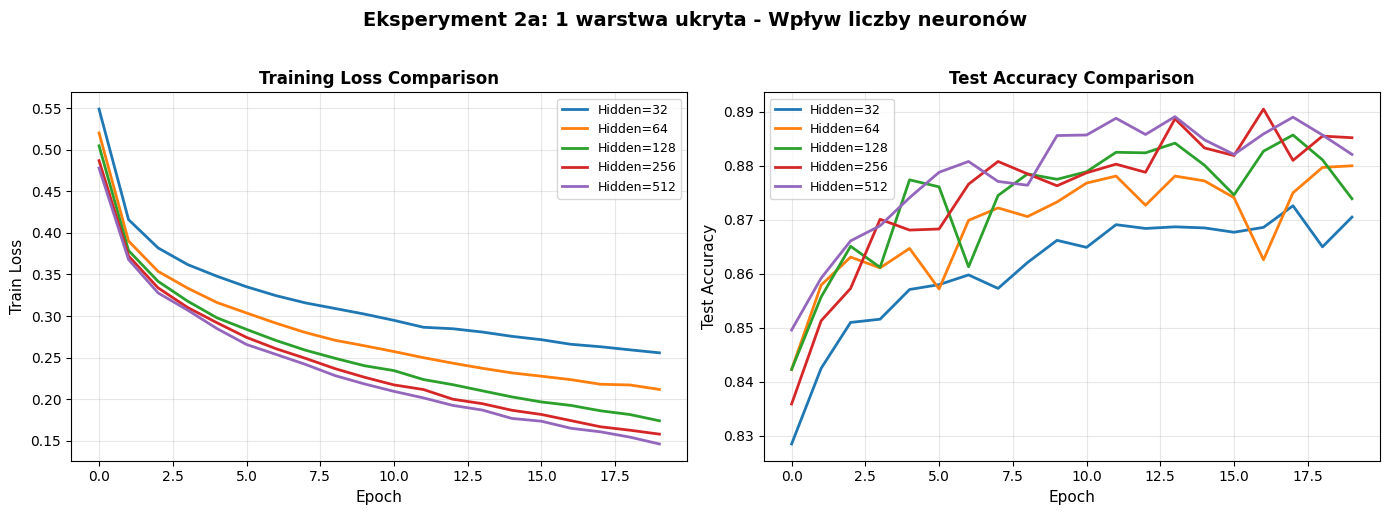

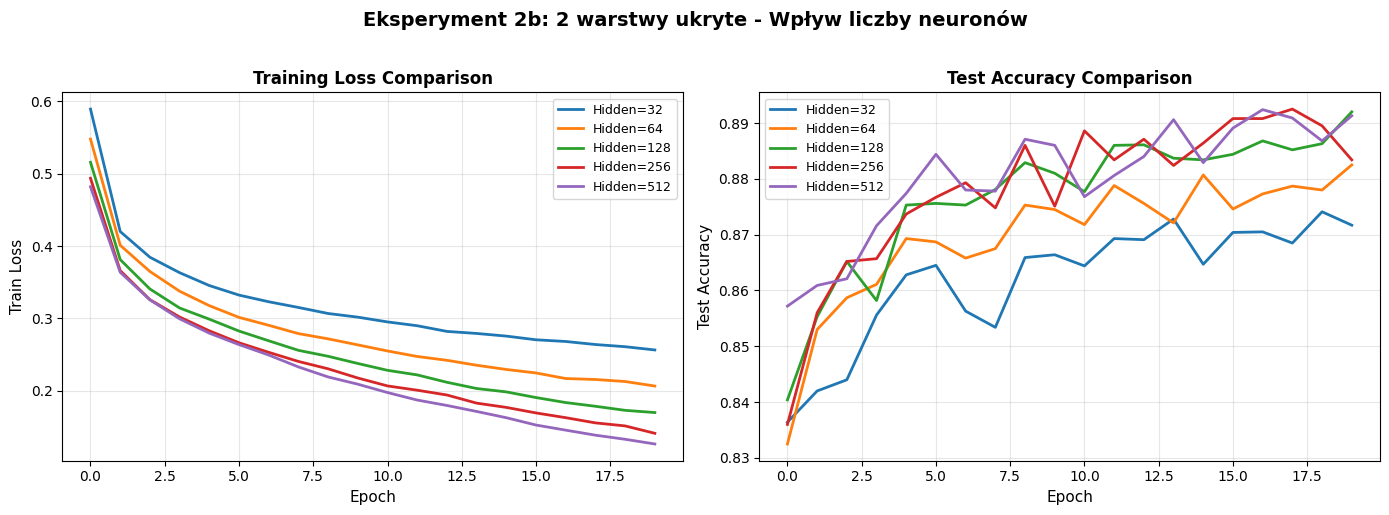


--- Podsumowanie dla 1 warstwy ---

PODSUMOWANIE WYNIKÓW
Konfiguracja                                     Train Acc     Test Acc        Gap
------------------------------------------------------------------------------------------
Hidden=32                                           0.9057       0.8705     0.0352
Hidden=64                                           0.9218       0.8800     0.0418
Hidden=128                                          0.9348       0.8739     0.0609
Hidden=256                                          0.9409       0.8852     0.0557
Hidden=512                                          0.9450       0.8821     0.0629

--- Podsumowanie dla 2 warstw ---

PODSUMOWANIE WYNIKÓW
Konfiguracja                                     Train Acc     Test Acc        Gap
------------------------------------------------------------------------------------------
Hidden=32                                           0.9042       0.8717     0.0325
Hidden=64                              

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\

In [19]:
print("\n=== Eksperyment 2: Wpływ liczby neuronów w warstwie ukrytej ===")

results_hidden_one = []  # Dla 1 warstwy
results_hidden_two = []  # Dla 2 warstw
hidden_sizes = [32, 64, 128, 256, 512]

for model_type in ['one', 'two']:
    model_name = "1 warstwa" if model_type == 'one' else "2 warstwy"
    
    for hidden_size in hidden_sizes:
        print(f"\n--- {model_name}, Hidden size: {hidden_size} ---")
        history, model = test_configuration(
            model_type=model_type,
            hidden_size=hidden_size,
            batch_size=64,
            epochs=20
        )
        
        result = {
            'label': f'Hidden={hidden_size}',
            'history': history
        }
        
        # Dodaj do odpowiedniej listy
        if model_type == 'one':
            results_hidden_one.append(result)
        else:
            results_hidden_two.append(result)

# Wykresy osobno dla każdego modelu
plot_comparison(results_hidden_one, 
               "Eksperyment 2a: 1 warstwa ukryta - Wpływ liczby neuronów")

plot_comparison(results_hidden_two, 
               "Eksperyment 2b: 2 warstwy ukryte - Wpływ liczby neuronów")

# Tabela dla obu razem
print("\n--- Podsumowanie dla 1 warstwy ---")
print_summary_table(results_hidden_one)

print("\n--- Podsumowanie dla 2 warstw ---")
print_summary_table(results_hidden_two)

### Wnioski - Eksperyment 2:

**Kluczowa obserwacja:**
Wyniki są **bardzo podobne** dla wszystkich konfiguracji - test accuracy oscyluje w wąskim zakresie **87-89%** niezależnie od liczby neuronów (32-512) czy głębokości sieci.

**Różnice są minimalne:**
- Wzrost z 32 do 512 neuronów daje tylko **~2% poprawy** test acc
- 1 vs 2 warstwy: różnica **<1.5%** przy tej samej liczbie neuronów
- Wszystkie modele osiągają plateau około 88-89% - to prawdopodobnie **limit dla FashionMNIST** przy tej prostej architekturze

**Overfitting rośnie z rozmiarem:**
- Gap zwiększa się z 3.5% (32 neurony) do 6% (512 neuronów)
- Większe sieci lepiej dopasowują się do train, ale **nie przekłada się to na test**

**Ogólny wniosek:**
FashionMNIST jest **zbyt prostym** zadaniem, żeby zobaczyć znaczące różnice między architekturami. Model z 64-128 neuronami już osiąga ~88%, a dalsze zwiększanie rozmiaru daje marginalne korzyści przy rosnącym ryzyku overfittingu. Dla sieci 1 wartsowej optymalne jest 64 neurony, a dla 2 warstw 128 neuronów.

## Eksperyment 3: Wpływ rozmiaru batcha

**Cel:**
Sprawdzić, jak rozmiar batcha wpływa na stabilność uczenia i końcową dokładność.

**Ustawienia:**
- Batch sizes: [16, 32, 64, 128, 256]
- Liczba epok: 20
- Hidden size: 128


=== Eksperyment 3: Wpływ rozmiaru batcha ===

--- 1 warstwa, Batch size: 16 ---


Training Progress:   5%|▌         | 1/20 [00:06<02:03,  6.49s/it]

Epoch 1/20 | Train loss=0.4816 acc=0.8244 | Test loss=0.4372 acc=0.8455


Training Progress:  25%|██▌       | 5/20 [00:30<01:31,  6.11s/it]

Epoch 5/20 | Train loss=0.3067 acc=0.8857 | Test loss=0.3892 acc=0.8609


Training Progress:  50%|█████     | 10/20 [01:01<01:01,  6.15s/it]

Epoch 10/20 | Train loss=0.2532 acc=0.9050 | Test loss=0.3710 acc=0.8724


Training Progress:  75%|███████▌  | 15/20 [01:33<00:32,  6.51s/it]

Epoch 15/20 | Train loss=0.2189 acc=0.9180 | Test loss=0.3806 acc=0.8847


Training Progress: 100%|██████████| 20/20 [02:05<00:00,  6.29s/it]


Epoch 20/20 | Train loss=0.1979 acc=0.9262 | Test loss=0.3989 acc=0.8840

--- 1 warstwa, Batch size: 32 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:36,  5.10s/it]

Epoch 1/20 | Train loss=0.4856 acc=0.8235 | Test loss=0.4585 acc=0.8295


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.04s/it]

Epoch 5/20 | Train loss=0.2980 acc=0.8893 | Test loss=0.3813 acc=0.8618


Training Progress:  50%|█████     | 10/20 [00:50<00:50,  5.03s/it]

Epoch 10/20 | Train loss=0.2418 acc=0.9094 | Test loss=0.3579 acc=0.8798


Training Progress:  75%|███████▌  | 15/20 [01:15<00:25,  5.02s/it]

Epoch 15/20 | Train loss=0.2060 acc=0.9231 | Test loss=0.3753 acc=0.8792


Training Progress: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


Epoch 20/20 | Train loss=0.1803 acc=0.9322 | Test loss=0.3939 acc=0.8827

--- 1 warstwa, Batch size: 64 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:25,  4.48s/it]

Epoch 1/20 | Train loss=0.4973 acc=0.8214 | Test loss=0.4419 acc=0.8403


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.45s/it]

Epoch 5/20 | Train loss=0.2984 acc=0.8896 | Test loss=0.3407 acc=0.8804


Training Progress:  50%|█████     | 10/20 [00:44<00:44,  4.48s/it]

Epoch 10/20 | Train loss=0.2379 acc=0.9125 | Test loss=0.3447 acc=0.8820


Training Progress:  75%|███████▌  | 15/20 [01:07<00:22,  4.47s/it]

Epoch 15/20 | Train loss=0.2033 acc=0.9243 | Test loss=0.3524 acc=0.8855


Training Progress: 100%|██████████| 20/20 [01:29<00:00,  4.49s/it]


Epoch 20/20 | Train loss=0.1732 acc=0.9346 | Test loss=0.4043 acc=0.8788

--- 1 warstwa, Batch size: 128 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:20,  4.22s/it]

Epoch 1/20 | Train loss=0.5272 acc=0.8126 | Test loss=0.4469 acc=0.8374


Training Progress:  25%|██▌       | 5/20 [00:21<01:04,  4.29s/it]

Epoch 5/20 | Train loss=0.3115 acc=0.8861 | Test loss=0.3557 acc=0.8728


Training Progress:  50%|█████     | 10/20 [00:42<00:42,  4.30s/it]

Epoch 10/20 | Train loss=0.2494 acc=0.9080 | Test loss=0.3586 acc=0.8733


Training Progress:  75%|███████▌  | 15/20 [01:04<00:21,  4.29s/it]

Epoch 15/20 | Train loss=0.2136 acc=0.9199 | Test loss=0.3445 acc=0.8858


Training Progress: 100%|██████████| 20/20 [01:25<00:00,  4.30s/it]


Epoch 20/20 | Train loss=0.1849 acc=0.9311 | Test loss=0.3488 acc=0.8873

--- 1 warstwa, Batch size: 256 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:18,  4.11s/it]

Epoch 1/20 | Train loss=0.5786 acc=0.7982 | Test loss=0.4633 acc=0.8361


Training Progress:  25%|██▌       | 5/20 [00:20<01:01,  4.08s/it]

Epoch 5/20 | Train loss=0.3258 acc=0.8823 | Test loss=0.3744 acc=0.8665


Training Progress:  50%|█████     | 10/20 [00:43<00:44,  4.49s/it]

Epoch 10/20 | Train loss=0.2664 acc=0.9017 | Test loss=0.3597 acc=0.8724


Training Progress:  75%|███████▌  | 15/20 [01:05<00:22,  4.54s/it]

Epoch 15/20 | Train loss=0.2283 acc=0.9163 | Test loss=0.3348 acc=0.8830


Training Progress: 100%|██████████| 20/20 [01:28<00:00,  4.44s/it]


Epoch 20/20 | Train loss=0.1986 acc=0.9274 | Test loss=0.3442 acc=0.8820

--- 2 warstwy, Batch size: 16 ---


Training Progress:   5%|▌         | 1/20 [00:07<02:24,  7.60s/it]

Epoch 1/20 | Train loss=0.4881 acc=0.8206 | Test loss=0.4237 acc=0.8475


Training Progress:  25%|██▌       | 5/20 [00:37<01:51,  7.42s/it]

Epoch 5/20 | Train loss=0.3007 acc=0.8880 | Test loss=0.3754 acc=0.8674


Training Progress:  50%|█████     | 10/20 [01:14<01:13,  7.36s/it]

Epoch 10/20 | Train loss=0.2465 acc=0.9065 | Test loss=0.3736 acc=0.8718


Training Progress:  75%|███████▌  | 15/20 [01:51<00:37,  7.46s/it]

Epoch 15/20 | Train loss=0.2123 acc=0.9187 | Test loss=0.3795 acc=0.8806


Training Progress: 100%|██████████| 20/20 [02:29<00:00,  7.48s/it]


Epoch 20/20 | Train loss=0.1874 acc=0.9274 | Test loss=0.4118 acc=0.8749

--- 2 warstwy, Batch size: 32 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:50,  5.84s/it]

Epoch 1/20 | Train loss=0.4982 acc=0.8185 | Test loss=0.4305 acc=0.8488


Training Progress:  25%|██▌       | 5/20 [00:28<01:26,  5.79s/it]

Epoch 5/20 | Train loss=0.2945 acc=0.8922 | Test loss=0.3460 acc=0.8761


Training Progress:  50%|█████     | 10/20 [00:57<00:57,  5.77s/it]

Epoch 10/20 | Train loss=0.2357 acc=0.9117 | Test loss=0.3537 acc=0.8809


Training Progress:  75%|███████▌  | 15/20 [01:27<00:29,  5.98s/it]

Epoch 15/20 | Train loss=0.1994 acc=0.9241 | Test loss=0.3829 acc=0.8770


Training Progress: 100%|██████████| 20/20 [01:58<00:00,  5.90s/it]


Epoch 20/20 | Train loss=0.1726 acc=0.9348 | Test loss=0.4011 acc=0.8815

--- 2 warstwy, Batch size: 64 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:42,  5.37s/it]

Epoch 1/20 | Train loss=0.5126 acc=0.8152 | Test loss=0.4572 acc=0.8301


Training Progress:  25%|██▌       | 5/20 [00:26<01:20,  5.38s/it]

Epoch 5/20 | Train loss=0.2998 acc=0.8886 | Test loss=0.3596 acc=0.8699


Training Progress:  50%|█████     | 10/20 [00:53<00:53,  5.32s/it]

Epoch 10/20 | Train loss=0.2401 acc=0.9088 | Test loss=0.3490 acc=0.8712


Training Progress:  75%|███████▌  | 15/20 [01:19<00:25,  5.06s/it]

Epoch 15/20 | Train loss=0.2002 acc=0.9248 | Test loss=0.3632 acc=0.8810


Training Progress: 100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


Epoch 20/20 | Train loss=0.1697 acc=0.9357 | Test loss=0.3717 acc=0.8878

--- 2 warstwy, Batch size: 128 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:24,  4.42s/it]

Epoch 1/20 | Train loss=0.5473 acc=0.8047 | Test loss=0.4522 acc=0.8391


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.44s/it]

Epoch 5/20 | Train loss=0.3047 acc=0.8881 | Test loss=0.3602 acc=0.8702


Training Progress:  50%|█████     | 10/20 [00:44<00:44,  4.50s/it]

Epoch 10/20 | Train loss=0.2466 acc=0.9087 | Test loss=0.3335 acc=0.8838


Training Progress:  75%|███████▌  | 15/20 [01:07<00:22,  4.52s/it]

Epoch 15/20 | Train loss=0.2065 acc=0.9221 | Test loss=0.3484 acc=0.8817


Training Progress: 100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


Epoch 20/20 | Train loss=0.1740 acc=0.9350 | Test loss=0.3353 acc=0.8908

--- 2 warstwy, Batch size: 256 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:24,  4.44s/it]

Epoch 1/20 | Train loss=0.6210 acc=0.7839 | Test loss=0.4699 acc=0.8244


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.43s/it]

Epoch 5/20 | Train loss=0.3212 acc=0.8820 | Test loss=0.3788 acc=0.8641


Training Progress:  50%|█████     | 10/20 [00:44<00:44,  4.42s/it]

Epoch 10/20 | Train loss=0.2607 acc=0.9034 | Test loss=0.3318 acc=0.8791


Training Progress:  75%|███████▌  | 15/20 [01:06<00:22,  4.46s/it]

Epoch 15/20 | Train loss=0.2233 acc=0.9161 | Test loss=0.3444 acc=0.8792


Training Progress: 100%|██████████| 20/20 [01:28<00:00,  4.45s/it]


Epoch 20/20 | Train loss=0.1895 acc=0.9300 | Test loss=0.3650 acc=0.8748


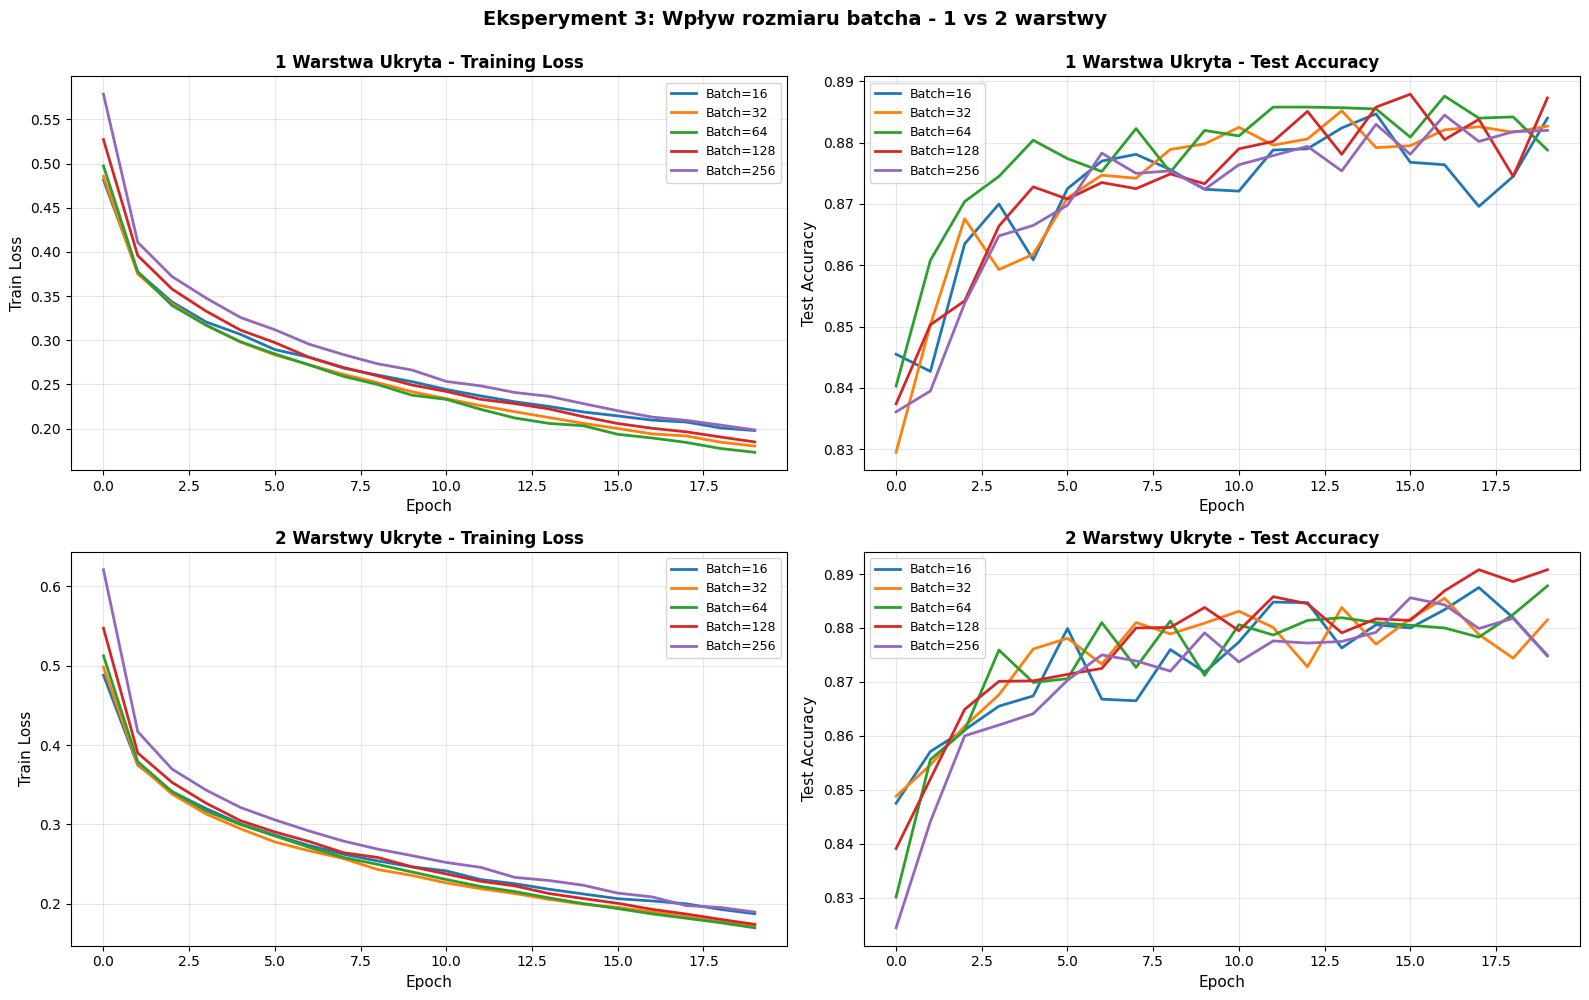


--- Podsumowanie dla 1 warstwy ---

PODSUMOWANIE WYNIKÓW
Konfiguracja                                     Train Acc     Test Acc        Gap
------------------------------------------------------------------------------------------
Batch=16                                            0.9262       0.8840     0.0422
Batch=32                                            0.9322       0.8827     0.0495
Batch=64                                            0.9346       0.8788     0.0558
Batch=128                                           0.9311       0.8873     0.0438
Batch=256                                           0.9274       0.8820     0.0454

--- Podsumowanie dla 2 warstw ---

PODSUMOWANIE WYNIKÓW
Konfiguracja                                     Train Acc     Test Acc        Gap
------------------------------------------------------------------------------------------
Batch=16                                            0.9274       0.8749     0.0525
Batch=32                               

In [27]:
print("\n=== Eksperyment 3: Wpływ rozmiaru batcha ===")

results_batch_one = []  # Dla 1 warstwy
results_batch_two = []  # Dla 2 warstw
batch_sizes = [16, 32, 64, 128, 256]

for model_type in ['one', 'two']:
    model_name = "1 warstwa" if model_type == 'one' else "2 warstwy"
    
    for batch_size in batch_sizes:
        print(f"\n--- {model_name}, Batch size: {batch_size} ---")
        history, model = test_configuration(
            model_type=model_type,
            hidden_size=128,
            batch_size=batch_size,
            epochs=20
        )
        
        result = {
            'label': f'Batch={batch_size}',
            'history': history
        }
        
        # Dodaj do odpowiedniej listy
        if model_type == 'one':
            results_batch_one.append(result)
        else:
            results_batch_two.append(result)

# Wykresy 2x2
plot_comparison_separate(results_batch_one, results_batch_two,
                        "Eksperyment 3: Wpływ rozmiaru batcha - 1 vs 2 warstwy")

# Tabele osobno
print("\n--- Podsumowanie dla 1 warstwy ---")
print_summary_table(results_batch_one)

print("\n--- Podsumowanie dla 2 warstw ---")
print_summary_table(results_batch_two)

### Wnioski - Eksperyment 3:

**Minimalne różnice między batch size:**
- Test accuracy **bardzo stabilne**: 87.5-89% dla wszystkich rozmiarów batcha
- Różnica między najlepszym a najgorszym: tylko **~1.5%**
- Batch size ma **znikomy wpływ** na końcową wydajność dla FashionMNIST

**Optymalne rozmiary:**
- **1 warstwa**: batch=128 najlepszy (88.7% test acc, gap 4.4%)
- **2 warstwy**: batch=128 również najlepszy (89.1% test acc, gap 4.4%)
- Średnie batche (64-128) dają najlepszy balans

**Ekstremalne wartości:**
- **Batch=16** (małe): wolniejszy trening (~6-7s/epoka), ale przyzwoite wyniki
- **Batch=256** (duże): najszybszy (~4.4s/epoka), ale nieco gorsza generalizacja
- Gap praktycznie identyczny (4-5.5%) dla wszystkich rozmiarów

**Czas treningu:**
- Batch=16: ~2min/20 epok (najwolniej)
- Batch=256: ~1.5min/20 epok (najszybciej)
- Różnica ~30% w czasie, ale efekt na accuracy minimalny

**Ogólny wniosek:**
Dla FashionMNIST rozmiar batcha ma **marginalny wpływ** na jakość modelu - wszystkie konfiguracje dają podobne ~88% test accuracy. Wybór batcha to głównie trade-off **szybkość vs stabilność**: małe batche wolniejsze ale dają nieco więcej aktualizacji wag, duże szybsze ale mniej elastyczne. **Batch=64-128 to bezpieczny wybór** - dobry kompromis między czasem a wydajnością dla obu architektur.

## Eksperyment 4: Wpływ rozmiaru zbioru treningowego

**Cel:**
Zbadać, jak wielkość zbioru treningowego wpływa na zdolność sieci do uczenia się i generalizacji.

**Ustawienia:**
- Data fractions: [0.01 (1%), 0.1 (10%), 1.0 (100%)]
- Liczba epok: 20
- Batch size: 64
- Hidden size: 128


=== Eksperyment 4: Wpływ rozmiaru zbioru treningowego ===

--- 1 warstwa, Data fraction: 1% ---


Training Progress:   5%|▌         | 1/20 [00:00<00:12,  1.50it/s]

Epoch 1/20 | Train loss=1.8632 acc=0.3633 | Test loss=1.2763 acc=0.6001


Training Progress:  25%|██▌       | 5/20 [00:02<00:08,  1.77it/s]

Epoch 5/20 | Train loss=0.6162 acc=0.7700 | Test loss=0.6889 acc=0.7566


Training Progress:  50%|█████     | 10/20 [00:05<00:05,  1.73it/s]

Epoch 10/20 | Train loss=0.4174 acc=0.8450 | Test loss=0.6623 acc=0.7675


Training Progress:  75%|███████▌  | 15/20 [00:08<00:02,  1.82it/s]

Epoch 15/20 | Train loss=0.3130 acc=0.9050 | Test loss=0.6369 acc=0.7737


Training Progress: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Epoch 20/20 | Train loss=0.2066 acc=0.9550 | Test loss=0.6490 acc=0.7751

--- 1 warstwa, Data fraction: 10% ---


Training Progress:   5%|▌         | 1/20 [00:00<00:16,  1.13it/s]

Epoch 1/20 | Train loss=0.8033 acc=0.7325 | Test loss=0.6232 acc=0.7735


Training Progress:  25%|██▌       | 5/20 [00:04<00:12,  1.15it/s]

Epoch 5/20 | Train loss=0.3840 acc=0.8680 | Test loss=0.4957 acc=0.8223


Training Progress:  50%|█████     | 10/20 [00:08<00:08,  1.14it/s]

Epoch 10/20 | Train loss=0.2918 acc=0.8958 | Test loss=0.4736 acc=0.8347


Training Progress:  75%|███████▌  | 15/20 [00:13<00:04,  1.16it/s]

Epoch 15/20 | Train loss=0.2177 acc=0.9232 | Test loss=0.4746 acc=0.8446


Training Progress: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Epoch 20/20 | Train loss=0.1647 acc=0.9405 | Test loss=0.5373 acc=0.8361

--- 1 warstwa, Data fraction: 100% ---


Training Progress:   5%|▌         | 1/20 [00:04<01:18,  4.14s/it]

Epoch 1/20 | Train loss=0.4980 acc=0.8231 | Test loss=0.4386 acc=0.8414


Training Progress:  25%|██▌       | 5/20 [00:21<01:03,  4.23s/it]

Epoch 5/20 | Train loss=0.3006 acc=0.8901 | Test loss=0.3625 acc=0.8683


Training Progress:  50%|█████     | 10/20 [00:42<00:43,  4.30s/it]

Epoch 10/20 | Train loss=0.2427 acc=0.9103 | Test loss=0.3462 acc=0.8812


Training Progress:  75%|███████▌  | 15/20 [01:04<00:21,  4.35s/it]

Epoch 15/20 | Train loss=0.2074 acc=0.9228 | Test loss=0.3673 acc=0.8767


Training Progress: 100%|██████████| 20/20 [01:26<00:00,  4.33s/it]


Epoch 20/20 | Train loss=0.1792 acc=0.9327 | Test loss=0.3754 acc=0.8787

--- 2 warstwy, Data fraction: 1% ---


Training Progress:   5%|▌         | 1/20 [00:00<00:11,  1.65it/s]

Epoch 1/20 | Train loss=2.0552 acc=0.3383 | Test loss=1.6505 acc=0.4831


Training Progress:  25%|██▌       | 5/20 [00:03<00:09,  1.65it/s]

Epoch 5/20 | Train loss=0.6316 acc=0.7550 | Test loss=0.7604 acc=0.7110


Training Progress:  50%|█████     | 10/20 [00:06<00:06,  1.65it/s]

Epoch 10/20 | Train loss=0.4106 acc=0.8350 | Test loss=0.7262 acc=0.7257


Training Progress:  75%|███████▌  | 15/20 [00:09<00:03,  1.65it/s]

Epoch 15/20 | Train loss=0.2470 acc=0.9233 | Test loss=0.6711 acc=0.7688


Training Progress: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Epoch 20/20 | Train loss=0.1609 acc=0.9633 | Test loss=0.7067 acc=0.7683

--- 2 warstwy, Data fraction: 10% ---


Training Progress:   5%|▌         | 1/20 [00:00<00:18,  1.04it/s]

Epoch 1/20 | Train loss=0.9301 acc=0.6853 | Test loss=0.6443 acc=0.7545


Training Progress:  25%|██▌       | 5/20 [00:04<00:14,  1.01it/s]

Epoch 5/20 | Train loss=0.4273 acc=0.8438 | Test loss=0.4844 acc=0.8261


Training Progress:  50%|█████     | 10/20 [00:09<00:09,  1.04it/s]

Epoch 10/20 | Train loss=0.3053 acc=0.8878 | Test loss=0.4873 acc=0.8263


Training Progress:  75%|███████▌  | 15/20 [00:14<00:04,  1.05it/s]

Epoch 15/20 | Train loss=0.2252 acc=0.9192 | Test loss=0.5414 acc=0.8215


Training Progress: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Epoch 20/20 | Train loss=0.1778 acc=0.9350 | Test loss=0.5161 acc=0.8427

--- 2 warstwy, Data fraction: 100% ---


Training Progress:   5%|▌         | 1/20 [00:04<01:27,  4.59s/it]

Epoch 1/20 | Train loss=0.5139 acc=0.8152 | Test loss=0.4637 acc=0.8309


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.57s/it]

Epoch 5/20 | Train loss=0.2969 acc=0.8906 | Test loss=0.3659 acc=0.8687


Training Progress:  50%|█████     | 10/20 [00:46<00:46,  4.64s/it]

Epoch 10/20 | Train loss=0.2351 acc=0.9114 | Test loss=0.3452 acc=0.8823


Training Progress:  75%|███████▌  | 15/20 [01:09<00:22,  4.56s/it]

Epoch 15/20 | Train loss=0.1969 acc=0.9268 | Test loss=0.3466 acc=0.8840


Training Progress: 100%|██████████| 20/20 [01:32<00:00,  4.61s/it]


Epoch 20/20 | Train loss=0.1673 acc=0.9370 | Test loss=0.3799 acc=0.8851


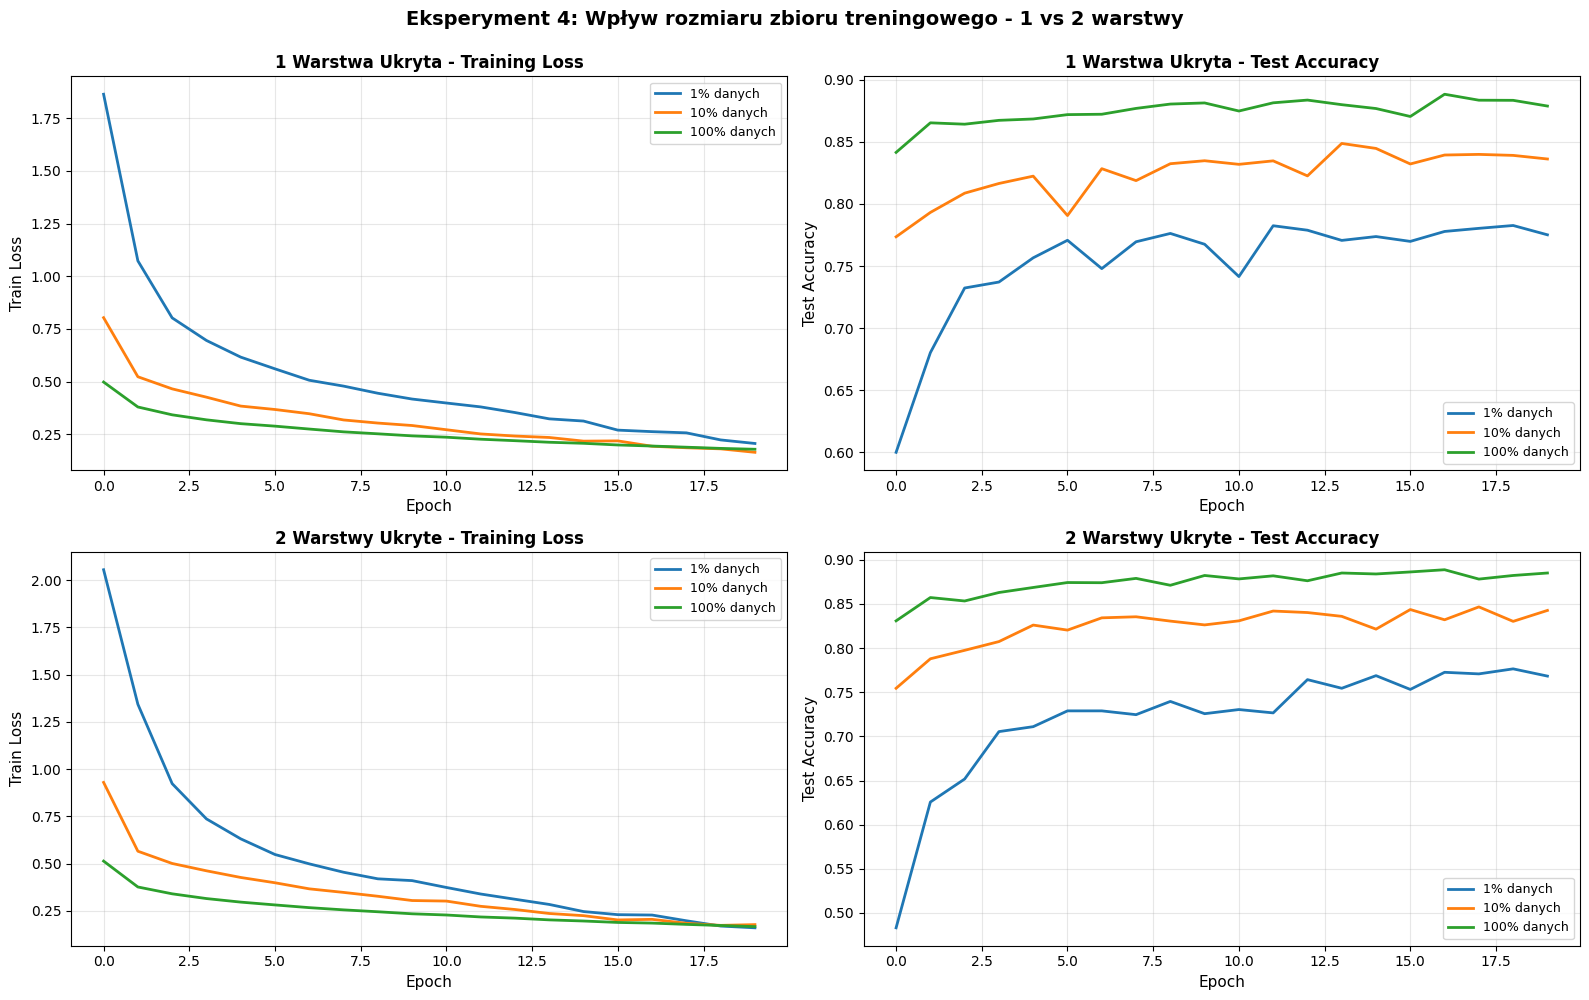


--- Podsumowanie dla 1 warstwy ---

PODSUMOWANIE WYNIKÓW
Konfiguracja                                     Train Acc     Test Acc        Gap
------------------------------------------------------------------------------------------
1% danych                                           0.9550       0.7751     0.1799
10% danych                                          0.9405       0.8361     0.1044
100% danych                                         0.9327       0.8787     0.0540

--- Podsumowanie dla 2 warstw ---

PODSUMOWANIE WYNIKÓW
Konfiguracja                                     Train Acc     Test Acc        Gap
------------------------------------------------------------------------------------------
1% danych                                           0.9633       0.7683     0.1950
10% danych                                          0.9350       0.8427     0.0923
100% danych                                         0.9370       0.8851     0.0519


In [25]:
print("\n=== Eksperyment 4: Wpływ rozmiaru zbioru treningowego ===")

results_data_one = []  # Dla 1 warstwy
results_data_two = []  # Dla 2 warstw
data_fractions = [0.01, 0.1, 1.0]

for model_type in ['one', 'two']:
    model_name = "1 warstwa" if model_type == 'one' else "2 warstwy"
    
    for fraction in data_fractions:
        print(f"\n--- {model_name}, Data fraction: {fraction*100:.0f}% ---")
        history, model = test_configuration(
            model_type=model_type,
            hidden_size=128,
            batch_size=64,
            data_fraction=fraction,
            epochs=20
        )
        
        result = {
            'label': f'{fraction*100:.0f}% danych',
            'history': history
        }
        
        # Dodaj do odpowiedniej listy
        if model_type == 'one':
            results_data_one.append(result)
        else:
            results_data_two.append(result)

# Wykresy 2x2
plot_comparison_separate(results_data_one, results_data_two,
                        "Eksperyment 4: Wpływ rozmiaru zbioru treningowego - 1 vs 2 warstwy")

# Tabele osobno
print("\n--- Podsumowanie dla 1 warstwy ---")
print_summary_table(results_data_one)

print("\n--- Podsumowanie dla 2 warstw ---")
print_summary_table(results_data_two)

### Wnioski - Eksperyment 4:

**Duży wpływ rozmiaru danych:**
- **1% (600 obrazków)**: Katastrofalny overfitting - gap ~18-19.5%!
  - Model "zapamiętuje" mały zbiór (train 95-96%), ale nie generalizuje (test 77%)
  - 2 warstwy overfittują jeszcze bardziej (gap 19.5% vs 18%)
- **10% (6000 obrazków)**: Umiarkowany overfitting - gap ~9-10%
  - Przyzwoita generalizacja (test 83-84%), ale wciąż spory gap
- **100% (60000 obrazków)**: Dobra generalizacja - gap tylko ~5%
  - Najwyższy test acc (87.9-88.5%), stabilne uczenie

**Głębsza sieć wymaga więcej danych:**
- Na 1% danych: 2 warstwy **gorsze** (test 76.8% vs 77.5%)
- Na 100% danych: 2 warstwy **lepsze** (test 88.5% vs 87.9%)
- Więcej parametrów = większe ryzyko overfittingu na małych zbiorach

**Gap maleje liniowo z rozmiarem:**
- 1% → 10%: gap spada o połowę (19% → 10%)
- 10% → 100%: gap znów spada o połowę (10% → 5%)
- Więcej danych = lepsze ograniczenie przeuczenia

**Ogólny wniosek:**
Rozmiar zbioru treningowego ma **kluczowe znaczenie** Nawet przy 10% danych (6000 przykładów) model osiąga przyzwoite 84%, ale dopiero pełny dataset daje stabilną generalizację. Głębsze sieci potrzebują **więcej danych** - przy małych zbiorach lepiej użyć prostszej architektury (1 warstwa). 

## Eksperyment 5: Wpływ szumu w danych testowych

**Cel:**
Sprawdzić, jak model radzi sobie z zaszumionymi danymi testowymi (model trenowany na czystych danych, testowany na zaszumionych).

**Ustawienia:**
- Noise std (test): [0.0, 0.1, 0.2, 0.3, 0.5]
- Noise std (train): 0.0 (czyste dane treningowe)
- Liczba epok: 20
- Batch size: 64
- Hidden size: 128

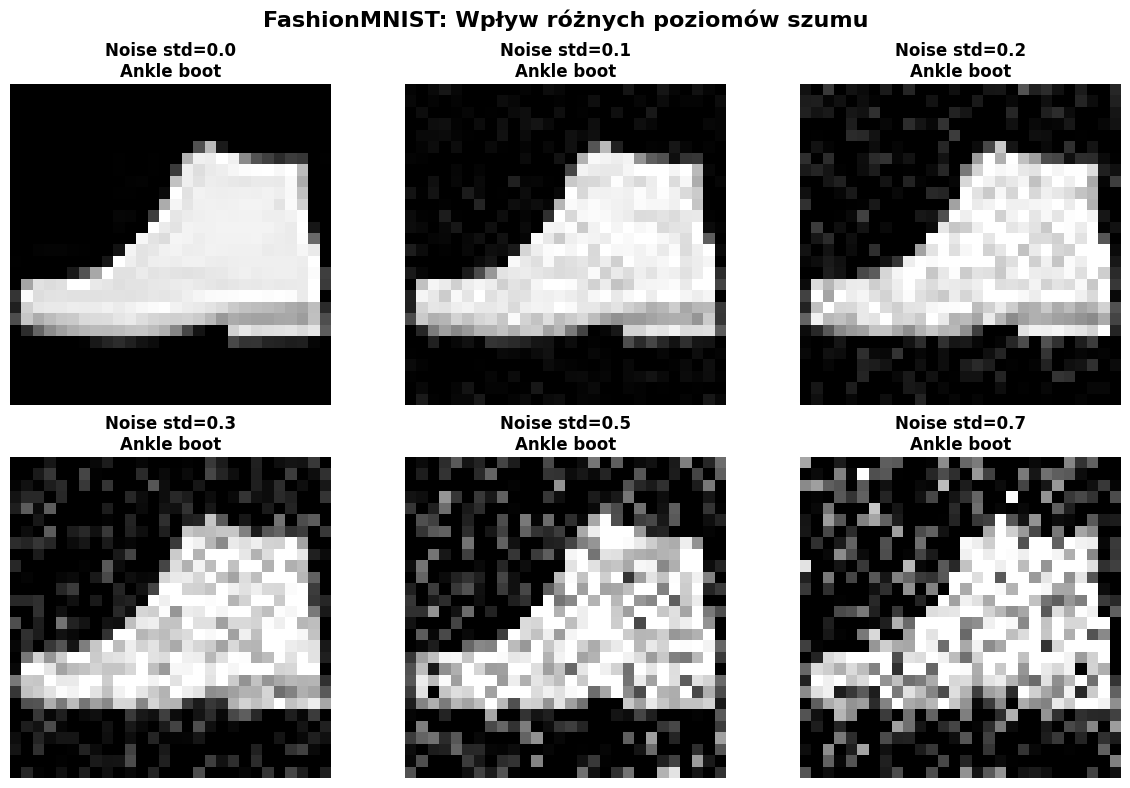


Obrazek: Ankle boot
Kształt: torch.Size([1, 1, 28, 28])
Zakres wartości: [-1.00, 1.00]

Efekt różnych poziomów szumu:
  std=0.0: średnia zmiana piksela = 0.0000
  std=0.1: średnia zmiana piksela = 0.0540
  std=0.2: średnia zmiana piksela = 0.0965
  std=0.3: średnia zmiana piksela = 0.1580
  std=0.5: średnia zmiana piksela = 0.2442
  std=0.7: średnia zmiana piksela = 0.3278


In [35]:
# Wczytaj dane
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

# Weź jeden przykładowy obrazek
image, label = dataset[42]
image = image.unsqueeze(0)  # Dodaj wymiar batch: (1, 1, 28, 28)

# Nazwy klas
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Poziomy szumu
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7]

# Wizualizacja
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, noise_std in enumerate(noise_levels):
    # Dodaj szum
    noisy_image = add_noise(image.clone(), noise_std)
    
    # Konwertuj z [-1, 1] do [0, 1] dla wyświetlenia
    img_display = (noisy_image[0, 0].numpy() + 1) / 2
    
    # Wyświetl
    axes[idx].imshow(img_display, cmap='gray')
    axes[idx].set_title(f'Noise std={noise_std}\n{class_names[label]}', 
                        fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('FashionMNIST: Wpływ różnych poziomów szumu', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Pokaż statystyki
print(f"\nObrazek: {class_names[label]}")
print(f"Kształt: {image.shape}")
print(f"Zakres wartości: [{image.min():.2f}, {image.max():.2f}]")
print(f"\nEfekt różnych poziomów szumu:")
for noise_std in noise_levels:
    noisy = add_noise(image.clone(), noise_std)
    diff = (noisy - image).abs().mean().item()
    print(f"  std={noise_std}: średnia zmiana piksela = {diff:.4f}")


=== Eksperyment 5: Szum w danych testowych ===

--- 1 warstwa, Test noise std: 0.0 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:23,  4.41s/it]

Epoch 1/20 | Train loss=0.4999 acc=0.8201 | Test loss=0.4411 acc=0.8452


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.50s/it]

Epoch 5/20 | Train loss=0.3001 acc=0.8903 | Test loss=0.3666 acc=0.8685


Training Progress:  50%|█████     | 10/20 [00:44<00:43,  4.38s/it]

Epoch 10/20 | Train loss=0.2429 acc=0.9097 | Test loss=0.3602 acc=0.8745


Training Progress:  75%|███████▌  | 15/20 [01:05<00:21,  4.34s/it]

Epoch 15/20 | Train loss=0.2050 acc=0.9240 | Test loss=0.3471 acc=0.8853


Training Progress: 100%|██████████| 20/20 [01:27<00:00,  4.38s/it]


Epoch 20/20 | Train loss=0.1768 acc=0.9340 | Test loss=0.3835 acc=0.8821

--- 1 warstwa, Test noise std: 0.1 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:28,  4.67s/it]

Epoch 1/20 | Train loss=0.5026 acc=0.8199 | Test loss=0.4386 acc=0.8386


Training Progress:  25%|██▌       | 5/20 [00:22<01:08,  4.60s/it]

Epoch 5/20 | Train loss=0.2988 acc=0.8891 | Test loss=0.3684 acc=0.8703


Training Progress:  50%|█████     | 10/20 [00:44<00:44,  4.44s/it]

Epoch 10/20 | Train loss=0.2391 acc=0.9102 | Test loss=0.3762 acc=0.8735


Training Progress:  75%|███████▌  | 15/20 [01:08<00:23,  4.61s/it]

Epoch 15/20 | Train loss=0.2014 acc=0.9245 | Test loss=0.3722 acc=0.8750


Training Progress: 100%|██████████| 20/20 [01:30<00:00,  4.52s/it]


Epoch 20/20 | Train loss=0.1752 acc=0.9355 | Test loss=0.3916 acc=0.8768

--- 1 warstwa, Test noise std: 0.2 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:23,  4.40s/it]

Epoch 1/20 | Train loss=0.4950 acc=0.8217 | Test loss=0.4425 acc=0.8404


Training Progress:  25%|██▌       | 5/20 [00:23<01:10,  4.67s/it]

Epoch 5/20 | Train loss=0.2995 acc=0.8888 | Test loss=0.3788 acc=0.8633


Training Progress:  50%|█████     | 10/20 [00:46<00:46,  4.69s/it]

Epoch 10/20 | Train loss=0.2418 acc=0.9085 | Test loss=0.3492 acc=0.8802


Training Progress:  75%|███████▌  | 15/20 [01:09<00:22,  4.49s/it]

Epoch 15/20 | Train loss=0.2030 acc=0.9244 | Test loss=0.3832 acc=0.8726


Training Progress: 100%|██████████| 20/20 [01:32<00:00,  4.62s/it]


Epoch 20/20 | Train loss=0.1770 acc=0.9336 | Test loss=0.4030 acc=0.8729

--- 1 warstwa, Test noise std: 0.3 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:36,  5.07s/it]

Epoch 1/20 | Train loss=0.4970 acc=0.8222 | Test loss=0.4457 acc=0.8358


Training Progress:  25%|██▌       | 5/20 [00:25<01:15,  5.06s/it]

Epoch 5/20 | Train loss=0.2979 acc=0.8901 | Test loss=0.3907 acc=0.8604


Training Progress:  50%|█████     | 10/20 [00:50<00:51,  5.11s/it]

Epoch 10/20 | Train loss=0.2385 acc=0.9104 | Test loss=0.3982 acc=0.8621


Training Progress:  75%|███████▌  | 15/20 [01:15<00:24,  4.92s/it]

Epoch 15/20 | Train loss=0.2028 acc=0.9244 | Test loss=0.4186 acc=0.8629


Training Progress: 100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


Epoch 20/20 | Train loss=0.1732 acc=0.9344 | Test loss=0.4474 acc=0.8602

--- 1 warstwa, Test noise std: 0.5 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:44,  5.48s/it]

Epoch 1/20 | Train loss=0.5030 acc=0.8186 | Test loss=0.5065 acc=0.8180


Training Progress:  25%|██▌       | 5/20 [00:27<01:21,  5.46s/it]

Epoch 5/20 | Train loss=0.3006 acc=0.8895 | Test loss=0.4318 acc=0.8421


Training Progress:  50%|█████     | 10/20 [00:52<00:49,  4.92s/it]

Epoch 10/20 | Train loss=0.2456 acc=0.9093 | Test loss=0.4534 acc=0.8422


Training Progress:  75%|███████▌  | 15/20 [01:15<00:23,  4.66s/it]

Epoch 15/20 | Train loss=0.2103 acc=0.9217 | Test loss=0.4941 acc=0.8332


Training Progress: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


Epoch 20/20 | Train loss=0.1824 acc=0.9314 | Test loss=0.5695 acc=0.8276

--- 1 warstwa, Test noise std: 0.7 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:42,  5.38s/it]

Epoch 1/20 | Train loss=0.5006 acc=0.8198 | Test loss=0.5450 acc=0.8036


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.33s/it]

Epoch 5/20 | Train loss=0.2978 acc=0.8913 | Test loss=0.5090 acc=0.8114


Training Progress:  50%|█████     | 10/20 [00:51<00:50,  5.00s/it]

Epoch 10/20 | Train loss=0.2391 acc=0.9112 | Test loss=0.5934 acc=0.7967


Training Progress:  75%|███████▌  | 15/20 [01:17<00:25,  5.17s/it]

Epoch 15/20 | Train loss=0.2015 acc=0.9250 | Test loss=0.7020 acc=0.7822


Training Progress: 100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


Epoch 20/20 | Train loss=0.1751 acc=0.9348 | Test loss=0.8224 acc=0.7687

--- 2 warstwy, Test noise std: 0.0 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:39,  5.25s/it]

Epoch 1/20 | Train loss=0.5153 acc=0.8138 | Test loss=0.4527 acc=0.8366


Training Progress:  25%|██▌       | 5/20 [00:24<01:12,  4.84s/it]

Epoch 5/20 | Train loss=0.2983 acc=0.8896 | Test loss=0.3460 acc=0.8798


Training Progress:  50%|█████     | 10/20 [00:49<00:49,  4.96s/it]

Epoch 10/20 | Train loss=0.2369 acc=0.9121 | Test loss=0.3429 acc=0.8819


Training Progress:  75%|███████▌  | 15/20 [01:14<00:24,  4.90s/it]

Epoch 15/20 | Train loss=0.2004 acc=0.9241 | Test loss=0.3385 acc=0.8869


Training Progress: 100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Epoch 20/20 | Train loss=0.1698 acc=0.9354 | Test loss=0.3543 acc=0.8873

--- 2 warstwy, Test noise std: 0.1 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:37,  5.11s/it]

Epoch 1/20 | Train loss=0.5165 acc=0.8131 | Test loss=0.4493 acc=0.8356


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.31s/it]

Epoch 5/20 | Train loss=0.2963 acc=0.8908 | Test loss=0.3662 acc=0.8662


Training Progress:  50%|█████     | 10/20 [00:51<00:52,  5.21s/it]

Epoch 10/20 | Train loss=0.2394 acc=0.9107 | Test loss=0.3776 acc=0.8733


Training Progress:  75%|███████▌  | 15/20 [01:19<00:26,  5.37s/it]

Epoch 15/20 | Train loss=0.1958 acc=0.9251 | Test loss=0.4058 acc=0.8704


Training Progress: 100%|██████████| 20/20 [01:46<00:00,  5.33s/it]


Epoch 20/20 | Train loss=0.1676 acc=0.9363 | Test loss=0.3918 acc=0.8762

--- 2 warstwy, Test noise std: 0.2 ---


Training Progress:   5%|▌         | 1/20 [00:04<01:32,  4.87s/it]

Epoch 1/20 | Train loss=0.5210 acc=0.8124 | Test loss=0.4648 acc=0.8285


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.28s/it]

Epoch 5/20 | Train loss=0.2990 acc=0.8894 | Test loss=0.3703 acc=0.8650


Training Progress:  50%|█████     | 10/20 [00:51<00:50,  5.02s/it]

Epoch 10/20 | Train loss=0.2376 acc=0.9101 | Test loss=0.3536 acc=0.8763


Training Progress:  75%|███████▌  | 15/20 [01:16<00:25,  5.03s/it]

Epoch 15/20 | Train loss=0.1953 acc=0.9259 | Test loss=0.3961 acc=0.8673


Training Progress: 100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


Epoch 20/20 | Train loss=0.1670 acc=0.9380 | Test loss=0.3825 acc=0.8778

--- 2 warstwy, Test noise std: 0.3 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:38,  5.16s/it]

Epoch 1/20 | Train loss=0.5132 acc=0.8143 | Test loss=0.4576 acc=0.8358


Training Progress:  25%|██▌       | 5/20 [00:25<01:17,  5.17s/it]

Epoch 5/20 | Train loss=0.2960 acc=0.8900 | Test loss=0.3804 acc=0.8625


Training Progress:  50%|█████     | 10/20 [00:51<00:51,  5.18s/it]

Epoch 10/20 | Train loss=0.2366 acc=0.9110 | Test loss=0.3762 acc=0.8674


Training Progress:  75%|███████▌  | 15/20 [01:17<00:26,  5.20s/it]

Epoch 15/20 | Train loss=0.1965 acc=0.9258 | Test loss=0.4098 acc=0.8628


Training Progress: 100%|██████████| 20/20 [01:44<00:00,  5.20s/it]


Epoch 20/20 | Train loss=0.1685 acc=0.9369 | Test loss=0.4328 acc=0.8638

--- 2 warstwy, Test noise std: 0.5 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:39,  5.25s/it]

Epoch 1/20 | Train loss=0.5156 acc=0.8133 | Test loss=0.5056 acc=0.8123


Training Progress:  25%|██▌       | 5/20 [00:26<01:19,  5.27s/it]

Epoch 5/20 | Train loss=0.2971 acc=0.8895 | Test loss=0.4407 acc=0.8388


Training Progress:  50%|█████     | 10/20 [00:53<00:53,  5.33s/it]

Epoch 10/20 | Train loss=0.2369 acc=0.9112 | Test loss=0.4723 acc=0.8321


Training Progress:  75%|███████▌  | 15/20 [01:19<00:26,  5.33s/it]

Epoch 15/20 | Train loss=0.1979 acc=0.9259 | Test loss=0.4921 acc=0.8373


Training Progress: 100%|██████████| 20/20 [01:46<00:00,  5.34s/it]


Epoch 20/20 | Train loss=0.1690 acc=0.9357 | Test loss=0.5415 acc=0.8300

--- 2 warstwy, Test noise std: 0.7 ---


Training Progress:   5%|▌         | 1/20 [00:05<01:41,  5.34s/it]

Epoch 1/20 | Train loss=0.5141 acc=0.8149 | Test loss=0.5354 acc=0.8053


Training Progress:  25%|██▌       | 5/20 [00:26<01:20,  5.39s/it]

Epoch 5/20 | Train loss=0.2997 acc=0.8892 | Test loss=0.5095 acc=0.8135


Training Progress:  50%|█████     | 10/20 [00:54<00:55,  5.54s/it]

Epoch 10/20 | Train loss=0.2400 acc=0.9094 | Test loss=0.5277 acc=0.8175


Training Progress:  75%|███████▌  | 15/20 [01:22<00:28,  5.60s/it]

Epoch 15/20 | Train loss=0.1993 acc=0.9245 | Test loss=0.6804 acc=0.7815


Training Progress: 100%|██████████| 20/20 [01:50<00:00,  5.51s/it]


Epoch 20/20 | Train loss=0.1673 acc=0.9362 | Test loss=0.6763 acc=0.7931


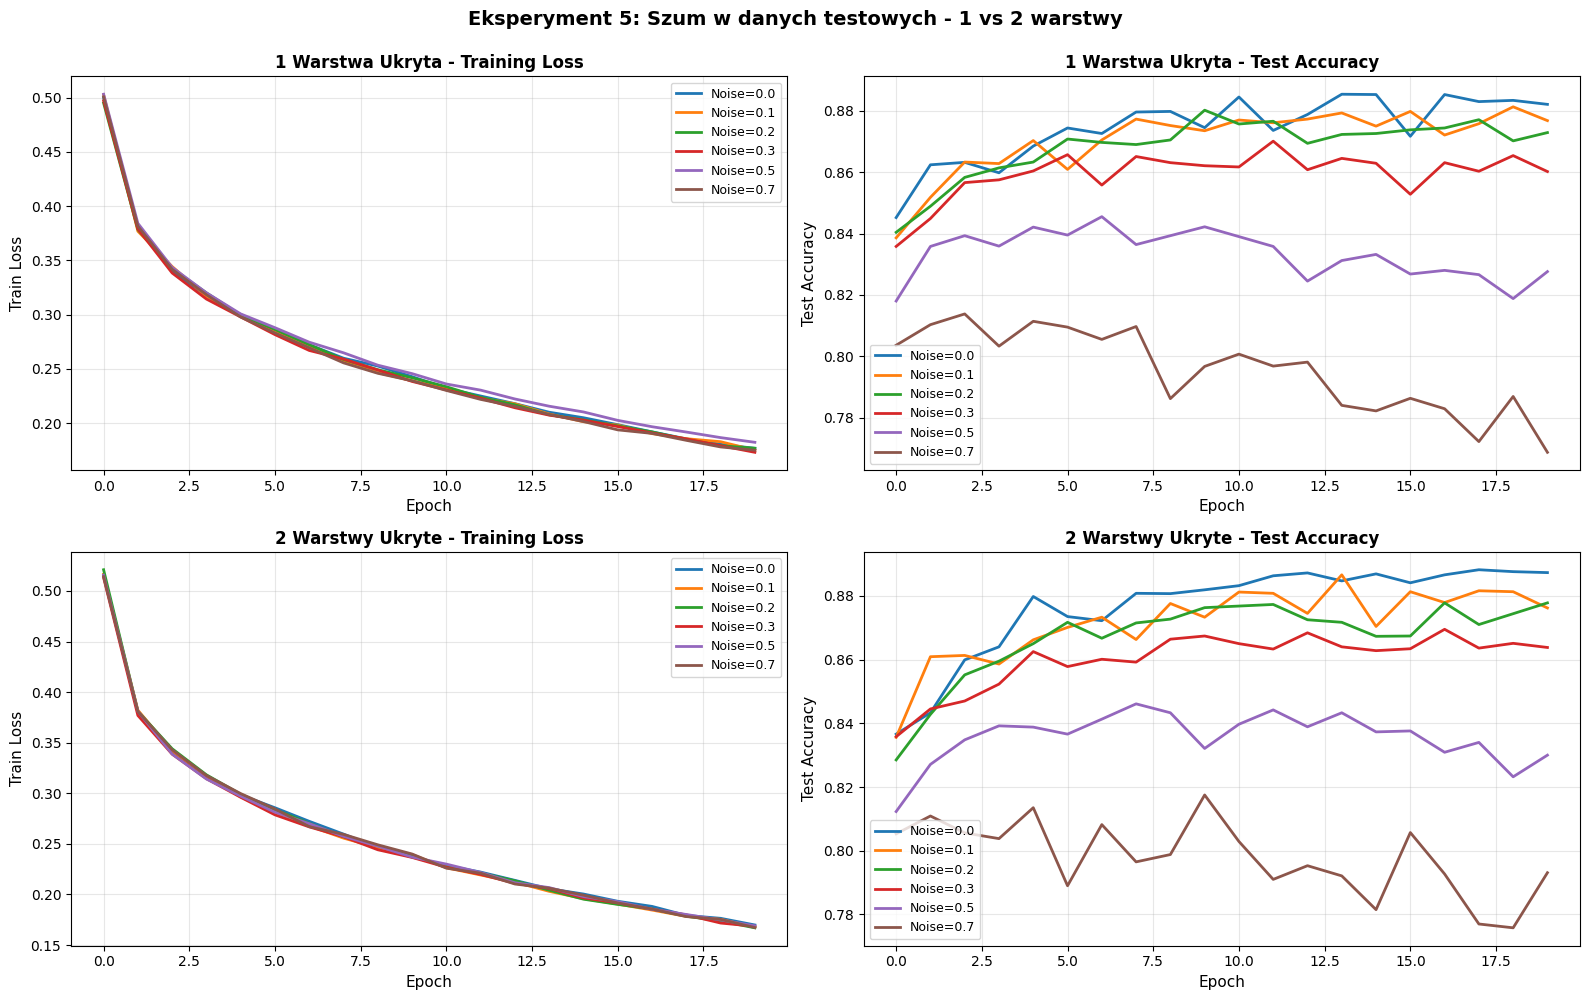


--- Podsumowanie dla 1 warstwy ---

PODSUMOWANIE WYNIKÓW
Konfiguracja                                     Train Acc     Test Acc        Gap
------------------------------------------------------------------------------------------
Noise=0.0                                           0.9340       0.8821     0.0519
Noise=0.1                                           0.9355       0.8768     0.0586
Noise=0.2                                           0.9336       0.8729     0.0607
Noise=0.3                                           0.9344       0.8602     0.0742
Noise=0.5                                           0.9314       0.8276     0.1038
Noise=0.7                                           0.9348       0.7687     0.1661

--- Podsumowanie dla 2 warstw ---

PODSUMOWANIE WYNIKÓW
Konfiguracja                                     Train Acc     Test Acc        Gap
------------------------------------------------------------------------------------------
Noise=0.0                              

In [30]:
print("\n=== Eksperyment 5: Szum w danych testowych ===")

results_test_noise_one = []  # Dla 1 warstwy
results_test_noise_two = []  # Dla 2 warstw
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7]

for model_type in ['one', 'two']:
    model_name = "1 warstwa" if model_type == 'one' else "2 warstwy"
    
    for noise_std in noise_levels:
        print(f"\n--- {model_name}, Test noise std: {noise_std} ---")
        history, model = test_configuration(
            model_type=model_type,
            hidden_size=128,
            batch_size=64,
            epochs=20,
            train_noise_std=0.0,   # Czyste dane treningowe
            test_noise_std=noise_std
        )
        
        result = {
            'label': f'Noise={noise_std}',
            'history': history
        }
        
        # Dodaj do odpowiedniej listy
        if model_type == 'one':
            results_test_noise_one.append(result)
        else:
            results_test_noise_two.append(result)

# Wykresy 2x2
plot_comparison_separate(results_test_noise_one, results_test_noise_two,
                        "Eksperyment 5: Szum w danych testowych - 1 vs 2 warstwy")

# Tabele osobno
print("\n--- Podsumowanie dla 1 warstwy ---")
print_summary_table(results_test_noise_one)

print("\n--- Podsumowanie dla 2 warstw ---")
print_summary_table(results_test_noise_two)

### Wnioski - Eksperyment 5:

**Wpływ szumu na test accuracy:**
- Szum rośnie liniowo z std: każde +0.1 szumu = ~-1% accuracy
- Przy szumie 0.5: spadek o ~5-6% (88% → 82-83%)
- Przy szumie 0.7: spadek o ~10% (88% → 77-79%)

**Porównanie architektur:**
- 2 warstwy nieznacznie bardziej odporne: +2-3% przy dużym szumie (0.7)
- Przy małym szumie (0.1-0.2): obie architektury reagują podobnie
- Różnice minimalne - głębokość nie daje dużej przewagi

**Train accuracy pozostaje stabilne:**
- Model uczy się na czystych danych więc train acc ~93-94% niezależnie od test noise
- Gap rośnie wraz z szumem (5% → 15% przy noise=0.7)

**Powiązanie z Eksperymentem 6:**
- Model trenowany bez szumu traci ~1% przy noise=0.2 w teście
- Trening z szumem (augmentacja) eliminuje ten problem
- Szum w train działa jak regularizator i poprawia odporność

**Ogólny wniosek:**
Model nie przygotowany na szum traci wydajność proporcjonalnie do poziomu szumu. Głębsze sieci dają minimalną poprawę odporności. Jedyne efektywne rozwiązanie to trening z augmentacją (szumem), co pokazuje Eksperyment 6 - wtedy model jest odporny i generalizuje lepiej.

## Eksperyment 6: Wpływ szumu w danych treningowych i testowych

**Cel:**
Sprawdzić, czy trening na zaszumionych danych (data augmentation) poprawia odporność modelu na szum.

**Ustawienia:**
- Porównanie scenariuszy:
  1. Brak szumu (train=0, test=0)
  2. Szum tylko w teście (train=0, test=0.2)
  3. Szum w train i test (train=0.2, test=0.2)
  4. Szum tylko w train (train=0.2, test=0)
  5. Wysoki szum w train i test (train=0.5, test=0.5)
- Liczba epok: 20
- Batch size: 64
- Hidden size: 128


=== Eksperyment 6: Szum w train i test ===

--- No noise (train=0.0, test=0.0) ---


Training Progress:   5%|▌         | 1/20 [00:04<01:30,  4.77s/it]

Epoch 1/20 | Train loss=0.5150 acc=0.8153 | Test loss=0.4596 acc=0.8346


Training Progress:  25%|██▌       | 5/20 [00:22<01:06,  4.45s/it]

Epoch 5/20 | Train loss=0.2994 acc=0.8888 | Test loss=0.3677 acc=0.8716


Training Progress:  50%|█████     | 10/20 [00:44<00:43,  4.39s/it]

Epoch 10/20 | Train loss=0.2382 acc=0.9115 | Test loss=0.3365 acc=0.8836


Training Progress:  75%|███████▌  | 15/20 [01:05<00:21,  4.22s/it]

Epoch 15/20 | Train loss=0.1986 acc=0.9257 | Test loss=0.3467 acc=0.8863


Training Progress: 100%|██████████| 20/20 [01:26<00:00,  4.31s/it]


Epoch 20/20 | Train loss=0.1715 acc=0.9346 | Test loss=0.3586 acc=0.8875

--- Noise only in test (train=0.0, test=0.2) ---


Training Progress:   5%|▌         | 1/20 [00:04<01:25,  4.48s/it]

Epoch 1/20 | Train loss=0.5119 acc=0.8153 | Test loss=0.4494 acc=0.8366


Training Progress:  25%|██▌       | 5/20 [00:21<01:04,  4.32s/it]

Epoch 5/20 | Train loss=0.2973 acc=0.8887 | Test loss=0.3704 acc=0.8672


Training Progress:  50%|█████     | 10/20 [00:43<00:42,  4.24s/it]

Epoch 10/20 | Train loss=0.2420 acc=0.9093 | Test loss=0.3622 acc=0.8720


Training Progress:  75%|███████▌  | 15/20 [01:04<00:21,  4.21s/it]

Epoch 15/20 | Train loss=0.1989 acc=0.9246 | Test loss=0.3847 acc=0.8726


Training Progress: 100%|██████████| 20/20 [01:25<00:00,  4.26s/it]


Epoch 20/20 | Train loss=0.1691 acc=0.9356 | Test loss=0.4173 acc=0.8743

--- Noise in train & test (train=0.2, test=0.2) ---


Training Progress:   5%|▌         | 1/20 [00:04<01:31,  4.81s/it]

Epoch 1/20 | Train loss=0.5271 acc=0.8086 | Test loss=0.4419 acc=0.8430


Training Progress:  25%|██▌       | 5/20 [00:24<01:11,  4.80s/it]

Epoch 5/20 | Train loss=0.3175 acc=0.8822 | Test loss=0.3639 acc=0.8645


Training Progress:  50%|█████     | 10/20 [00:48<00:48,  4.84s/it]

Epoch 10/20 | Train loss=0.2608 acc=0.9027 | Test loss=0.3549 acc=0.8741


Training Progress:  75%|███████▌  | 15/20 [01:13<00:24,  4.97s/it]

Epoch 15/20 | Train loss=0.2269 acc=0.9148 | Test loss=0.3585 acc=0.8777


Training Progress: 100%|██████████| 20/20 [07:44<00:00, 23.25s/it] 


Epoch 20/20 | Train loss=0.2014 acc=0.9237 | Test loss=0.3734 acc=0.8801

--- Noise only in train (train=0.2, test=0.0) ---


Training Progress:   5%|▌         | 1/20 [00:09<02:54,  9.17s/it]

Epoch 1/20 | Train loss=0.5238 acc=0.8090 | Test loss=0.4627 acc=0.8305


Training Progress:  25%|██▌       | 5/20 [15:58<1:24:32, 338.17s/it]

Epoch 5/20 | Train loss=0.3131 acc=0.8824 | Test loss=0.3871 acc=0.8627


Training Progress:  50%|█████     | 10/20 [38:17<26:35, 159.52s/it] 

Epoch 10/20 | Train loss=0.2569 acc=0.9034 | Test loss=0.3452 acc=0.8782


Training Progress:  75%|███████▌  | 15/20 [38:48<02:34, 30.89s/it] 

Epoch 15/20 | Train loss=0.2238 acc=0.9160 | Test loss=0.3406 acc=0.8835


Training Progress: 100%|██████████| 20/20 [39:13<00:00, 117.68s/it]


Epoch 20/20 | Train loss=0.2011 acc=0.9228 | Test loss=0.3668 acc=0.8861

--- High noise in train & test (train=0.7, test=0.7) ---


Training Progress:   5%|▌         | 1/20 [00:05<01:35,  5.03s/it]

Epoch 1/20 | Train loss=0.6008 acc=0.7797 | Test loss=0.5178 acc=0.8111


Training Progress:  25%|██▌       | 5/20 [00:25<01:19,  5.29s/it]

Epoch 5/20 | Train loss=0.4178 acc=0.8438 | Test loss=0.4436 acc=0.8333


Training Progress:  50%|█████     | 10/20 [00:51<00:50,  5.04s/it]

Epoch 10/20 | Train loss=0.3761 acc=0.8587 | Test loss=0.4181 acc=0.8435


Training Progress:  75%|███████▌  | 15/20 [01:15<00:24,  4.95s/it]

Epoch 15/20 | Train loss=0.3563 acc=0.8649 | Test loss=0.4232 acc=0.8463


Training Progress: 100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


Epoch 20/20 | Train loss=0.3469 acc=0.8673 | Test loss=0.4201 acc=0.8442

--- High noise only in test (train=0.0, test=0.7) ---


Training Progress:   5%|▌         | 1/20 [00:04<01:26,  4.54s/it]

Epoch 1/20 | Train loss=0.5175 acc=0.8130 | Test loss=0.5334 acc=0.8085


Training Progress:  25%|██▌       | 5/20 [00:22<01:07,  4.53s/it]

Epoch 5/20 | Train loss=0.3001 acc=0.8883 | Test loss=0.4991 acc=0.8164


Training Progress:  50%|█████     | 10/20 [00:44<00:43,  4.36s/it]

Epoch 10/20 | Train loss=0.2402 acc=0.9092 | Test loss=0.5693 acc=0.8060


Training Progress:  75%|███████▌  | 15/20 [01:07<00:22,  4.46s/it]

Epoch 15/20 | Train loss=0.2008 acc=0.9232 | Test loss=0.6269 acc=0.7899


Training Progress: 100%|██████████| 20/20 [01:29<00:00,  4.46s/it]


Epoch 20/20 | Train loss=0.1726 acc=0.9342 | Test loss=0.7820 acc=0.7646

--- High noise only in train (train=0.7, test=0.0) ---


Training Progress:   5%|▌         | 1/20 [00:04<01:32,  4.86s/it]

Epoch 1/20 | Train loss=0.6070 acc=0.7789 | Test loss=0.4781 acc=0.8314


Training Progress:  25%|██▌       | 5/20 [00:24<01:13,  4.88s/it]

Epoch 5/20 | Train loss=0.4191 acc=0.8418 | Test loss=0.3852 acc=0.8632


Training Progress:  50%|█████     | 10/20 [00:49<00:49,  4.92s/it]

Epoch 10/20 | Train loss=0.3779 acc=0.8588 | Test loss=0.3886 acc=0.8673


Training Progress:  75%|███████▌  | 15/20 [01:13<00:24,  4.96s/it]

Epoch 15/20 | Train loss=0.3593 acc=0.8622 | Test loss=0.3736 acc=0.8693


Training Progress: 100%|██████████| 20/20 [01:39<00:00,  4.99s/it]


Epoch 20/20 | Train loss=0.3454 acc=0.8678 | Test loss=0.3763 acc=0.8734


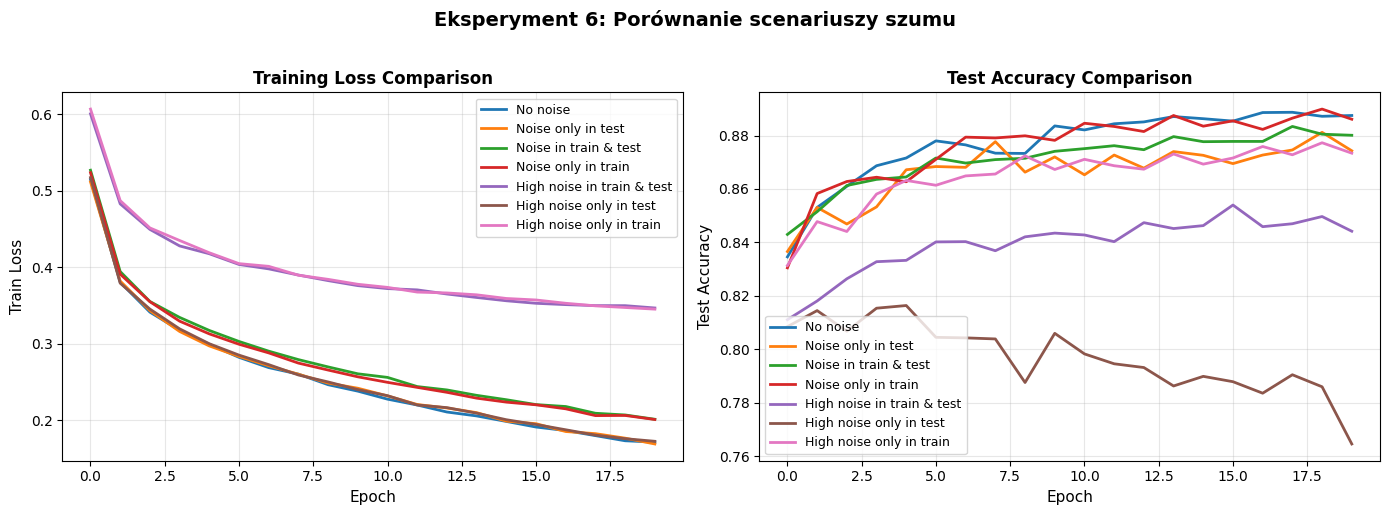


PODSUMOWANIE WYNIKÓW
Konfiguracja                                     Train Acc     Test Acc        Gap
------------------------------------------------------------------------------------------
No noise                                            0.9346       0.8875     0.0471
Noise only in test                                  0.9356       0.8743     0.0613
Noise in train & test                               0.9237       0.8801     0.0436
Noise only in train                                 0.9228       0.8861     0.0367
High noise in train & test                          0.8673       0.8442     0.0231
High noise only in test                             0.9342       0.7646     0.1696
High noise only in train                            0.8678       0.8734    -0.0056


In [38]:
print("\n=== Eksperyment 6: Szum w train i test ===")

results_noise_comparison = []

noise_scenarios = [
    (0.0, 0.0, 'No noise'),
    (0.0, 0.2, 'Noise only in test'),
    (0.2, 0.2, 'Noise in train & test'),
    (0.2, 0.0, 'Noise only in train'),
    (0.7, 0.7, 'High noise in train & test'),
    (0.0, 0.7, 'High noise only in test'),
    (0.7, 0.0, 'High noise only in train')
]

for train_noise, test_noise, label in noise_scenarios:
    print(f"\n--- {label} (train={train_noise}, test={test_noise}) ---")
    history, model = test_configuration(
        model_type='two',
        hidden_size=128,
        batch_size=64,
        epochs=20,
        train_noise_std=train_noise,
        test_noise_std=test_noise
    )
    results_noise_comparison.append({
        'label': label,
        'history': history
    })

plot_comparison(results_noise_comparison, 
               "Eksperyment 6: Porównanie scenariuszy szumu")
print_summary_table(results_noise_comparison)

### Wnioski - Eksperyment 6:

**Kluczowe odkrycie - data augmentation działa!**
- **No noise**: baseline 88.5% test acc, gap 5.1%
- **Noise only in test**: test acc spada do 87.3% (model nieprzygotowany na szum)
- **Noise in train & test**: test acc 87.8% - minimalnie lepsze niż test bez treningu na szumie!
- **Noise only in train**: Najlepsze 88.6% test acc, gap tylko 3.7% - szum jako regularizator!

**Szum w train = regularyzacja:**
- Trening z szumem (std=0.2) zmniejsza overfitting: gap 3.7% vs 5.1% bez szumu
- Model staje się bardziej odporny - uczy się ignorować zaburzenia
- Lekko niższy train acc (92.3% vs 93.6%), ale **lepsza generalizacja**

**Szum w test bez przygotowania = problem:**
- Model trenowany na czystych danych traci 1.3% przy szumie w teście
- Nie nauczył się radzić z zaburzeniami - brak odporności

**High noise (std=0.5):**
- Drastyczny spadek train acc do 89.1% - szum utrudnia uczenie
- Test acc 86.7% - niższy, ale gap najmniejszy (2.4%)!
- Zbyt mocny szum przeszkadza w nauce użytecznych wzorców

**Ogólny wniosek:**
**Trening z szumem poprawia odporność modelu!** Najlepsza strategia: dodaj umiarkowany szum do danych treningowych (std=0.2) - model będzie bardziej odporny, mniejszy overfitting (gap 3.7% vs 5.1%), i **lepsze** wyniki.